# LSTM Time Series Modeling
In this notebook, I will be building Long Short-Term Memory neural networks. These neural networks are a type of Recurrent Neural Network that is particularly adept at recalling past data and determining how much past information is useful or not useful for making predictions.

##### Disclaimer: This notebook should not be considered any kind of financial advice. It exists only for the purposes of practicing modeling and making predictions

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_validate, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import datetime as dt

pd.set_option("display.max_rows", 25)
pd.set_option('display.max_columns', 35)
sns.set_style("dark")

import warnings

# Suppress FutureWarnings for all of scikit-learn's modules
warnings.filterwarnings("ignore")

In [3]:
# New imports
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

from scikeras.wrappers import KerasRegressor


2023-11-16 11:44:00.351919: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<hr style="border: 2px solid blue">

### Functions

In [4]:
def test_metric_check(model, y_test, test_data):
    """
    Displays the RMSE, MSE, and R-Squared of a model on test data
    """
    y_preds = model.predict(test_data)
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_preds)), "MAE:", mean_absolute_error(y_test, y_preds),\
          "R-Squared:", r2_score(y_test, y_preds))

In [5]:
# Plotting Function

def plot_results(model, X_train, X_val, X_test, y_train, y_val, y_test):
    """
    Plot the predictions vs reality for train, validation, and test data.
    Requires the model and three feature samples
    
    """
    train_preds = model.predict(X_train).flatten()
    val_preds = model.predict(X_val).flatten()
    y_preds = model.predict(X_test).flatten()

    fig, ax = plt.subplots(nrows=3, figsize=(16,24))
    # plotting the training data

    ax[0].plot(list(price.index[:split_train]), train_preds, alpha = .5, linestyle=":")
    ax[0].plot(list(price.index[:split_train]), y_train, alpha = .5)
    ax[0].legend(["Predictions", "Training Data"])
    ax[0].set_title("Predictions on the Training Data");

    # plotting the validation data

    ax[1].plot(list(price.index[split_train:split_val]), val_preds, alpha = .5, linestyle=":")
    ax[1].plot(list(price.index[split_train:split_val]),y_val, alpha = .5)
    ax[1].legend(["Predictions", "Validation Data"])
    ax[1].set_title("Validation Data and Predictions");

    # plotting the test data

    ax[2].plot(list(price.index[split_val:]), y_preds, alpha=.5, linestyle=":")
    ax[2].plot(list(price.index[split_val:]), y_test, alpha=.5)
    ax[2].legend(["Predictions", "Reality"])
    ax[2].set_title("Test Data - Furthest Removed from Training");


    # 2nd plot with all the charts concatenated
    fig, ax = plt.subplots(figsize=(16,10))
    ax.plot(list(price.index[:split_train]), train_preds, alpha = .5, linestyle=":")
    ax.plot(list(price.index[:split_train]), y_train, alpha = .5, linestyle="--")


    ax.plot(list(price.index[split_train:split_val]), val_preds, alpha = .5, linestyle=":")
    ax.plot(list(price.index[split_train:split_val]), y_val, alpha = .5, linestyle="--")


    ax.plot(list(price.index[split_val:]), y_preds, linestyle=":", alpha=.5)
    ax.plot(list(price.index[split_val:]), y_test, alpha=.5)
    ax.legend(["Predictions", "Reality"])



    ax.legend(["Predictions", "Training Data", "Val Predictions", "Validation Data",\
                "Test Predictions", "Test Data"])
    ax.set_xlim(9000, 19500)
    ax.set_title("Training, Validation, and Test Predictions")
    ax.axvline(15030, linestyle=":")
    ax.axvline(17156, linestyle=":");

### Container for model metrics

In [6]:
# Creating an empty dataframe to track model performance
metric_df = pd.DataFrame(columns=["Name", "Train MAE", "Train MSE", 'Train RMSE', 'Train MAPE', 'Train R^2',\
                                 "Val MAE", "Val MSE", 'Val RMSE', 'Val MAPE', 'Val R^2', "Test MAE", "Test MSE", \
                                  'Test RMSE', 'Test MAPE', 'Test R^2'])

In [7]:
# Function to update the dataframe with specific model performance

def aggregate_model_stats(name, model, X_train, X_val, X_test, y_train, \
                          y_val, y_test):
    """
    Adds model performance data to an existing dataframe object
    """
    
    train_preds = model.predict(X_train).flatten()
    val_preds = model.predict(X_val).flatten()
    y_preds = model.predict(X_test).flatten()

    # training metrics
    train_mae = mean_absolute_error(y_train, train_preds)
    train_mse = mean_squared_error(y_train, train_preds)
    train_rmse = mean_squared_error(y_train, train_preds, squared=False)
    train_mape = mean_absolute_percentage_error(y_train, train_preds)
    train_r2 = r2_score(y_train, train_preds)
    
    # val metrics
    val_mae = mean_absolute_error(y_val, val_preds)
    val_mse = mean_squared_error(y_val, val_preds)
    val_rmse = mean_squared_error(y_val, val_preds, squared=False)
    val_mape = mean_absolute_percentage_error(y_val, val_preds)
    val_r2 = r2_score(y_val, val_preds)
    
    # test metrics
    test_mae = mean_absolute_error(y_test, y_preds)
    test_mse = mean_squared_error(y_test, y_preds)
    test_rmse = mean_squared_error(y_test, y_preds, squared=False)
    test_mape = mean_absolute_percentage_error(y_test, y_preds)
    test_r2 = r2_score(y_test, y_preds)
    
    metric_dict = {"Name": name, "Train MAE":train_mae, "Train MSE":train_mse, "Train RMSE":train_rmse, \
                  "Train MAPE":train_mape, "Train R^2": train_r2, "Val MAE":val_mae, "Val MSE":val_mse,\
                   "Val RMSE":val_rmse, "Val MAPE":val_mape, "Val R^2": val_r2, "Test MAE":test_mae, \
                   "Test MSE":test_mse, "Test RMSE":test_rmse, "Test MAPE":test_mape, "Test R^2": test_r2}
    metric_df.loc[len(metric_df)] = metric_dict
    

<hr style="border: 2px solid blue">

# Data

In [8]:
# Load the S&P Data
df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/INDICES_FILLED.csv')
df.head(2)

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,...,dollar_volume(M),Quarter,Month,cycle_year,day_of_week,one_months_later,three_months_later,six_months_later,twelve_months_later,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change,One_Month_Positive,Three_Month_Positive,Six_Month_Positive,Twelve_Month_Positive
0,1964-02-06,^GSPC,76.93,76.93,77.260002,76.470001,0.0,4110000.0,669.822,3.50,0.0024,0.0006,-0.0023,0.0004,0.0006,NaN,64.329769,...,316.1823,1,2,4,Thursday,1964-03-06,1964-05-06,1964-08-06,1965-02-08,0.017938,0.053685,0.057325,0.130248,1.0,1.0,1.0,1.0
1,1964-02-07,^GSPC,77.18,77.18,77.510002,76.660004,0.0,4710000.0,669.822,3.52,0.0037,-0.0006,0.0014,0.0008,0.0036,NaN,68.197375,...,363.5178,1,2,4,Friday,1964-03-09,1964-05-07,1964-08-07,1965-02-08,0.014900,0.051438,0.060637,0.126587,1.0,1.0,1.0,1.0


In [9]:
# Prepare the dataframe appropriately
df['Date'] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df["Quarter"] = df["Quarter"].astype(str)
df['Month'] = df['Month'].astype(str)
df['cycle_year'] = df['cycle_year'].astype(str)
# Isolate S&P 500 index
df = df[df['Ticker'] == "^GSPC"]

In [10]:
df.shape

(14634, 40)

### Preparation for LSTM Neural Network - Univariate Modeling

In [11]:
# Establishing price as the only variable

price = df[["Adj Close"]]

In [12]:
# Using the .shift() method to create feature columns for previous prices

price["1_Day_Ago"] = price["Adj Close"].shift(1)
price["2_Day_Ago"] = price["Adj Close"].shift(2)
price["3_Day_Ago"] = price["Adj Close"].shift(3)
price["4_Day_Ago"] = price["Adj Close"].shift(4)
price["5_Day_Ago"] = price["Adj Close"].shift(5)
price["6_Day_Ago"] = price["Adj Close"].shift(6)
price["7_Day_Ago"] = price["Adj Close"].shift(7)
price["8_Day_Ago"] = price["Adj Close"].shift(8)
price["9_Day_Ago"] = price["Adj Close"].shift(9)
price["10_Day_Ago"] = price["Adj Close"].shift(10)
price["11_Day_Ago"] = price["Adj Close"].shift(11)
price["12_Day_Ago"] = price["Adj Close"].shift(12)
price["13_Day_Ago"] = price["Adj Close"].shift(13)
price["14_Day_Ago"] = price["Adj Close"].shift(14)
price["15_Day_Ago"] = price["Adj Close"].shift(15)

In [13]:
# Inspecting the price data - verifying nulls end after 15 days worth of data
price[:16]

,Adj Close,1_Day_Ago,2_Day_Ago,3_Day_Ago,4_Day_Ago,5_Day_Ago,6_Day_Ago,7_Day_Ago,8_Day_Ago,9_Day_Ago,10_Day_Ago,11_Day_Ago,12_Day_Ago,13_Day_Ago,14_Day_Ago,15_Day_Ago
Date,,,,,,,,,,,,,,,,
1964-02-06,76.930000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-02-07,77.180000,76.930000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-02-10,77.050003,77.180000,76.930000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-02-11,77.330002,77.050003,77.180000,76.930000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-02-13,77.519997,77.330002,77.050003,77.180000,76.930000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-02-14,77.480003,77.519997,77.330002,77.050003,77.180000,76.930000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-02-17,77.459999,77.480003,77.519997,77.330002,77.050003,77.180000,76.930000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-02-18,77.470001,77.459999,77.480003,77.519997,77.330002,77.050003,77.180000,76.930000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-02-19,77.550003,77.470001,77.459999,77.480003,77.519997,77.330002,77.050003,77.180000,76.930000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Dropping first 15 days of the data to avoid nulls

In [14]:
# Drop the nulls
price.dropna(inplace=True)

# X data and Y data, then split by dates

In [15]:
# splitting the data between target and features

X = np.array(price.drop(columns=["Adj Close"]))
y = np.array(price["Adj Close"])

In [16]:
# qualities of the features
X.shape, type(X)

((14619, 15), numpy.ndarray)

In [17]:
# qualities of the target
y.shape, type(y)

((14619,), numpy.ndarray)

### Splitting the data
I will split the data into training, validation, and then leave a final hold-out set for testing the model. The train-val-test split needs to be done sequentially in order to prevent time data leakage. The data also needs to be re-shaped in order to have the correct dimensions for the LSTM model.

In [18]:
X = X.reshape(len(X), X.shape[1], 1)
X.shape

(14619, 15, 1)

In [137]:
# Train on 80% test on Validate on 80-90, test on 90-100
split_train = int(len(y) *.80)
split_val = int(len(y) *.90)

# Splits
X_train, y_train = X[:split_train], y[:split_train]
X_val, y_val = X[split_train:split_val], y[split_train:split_val]
X_test, y_test = X[split_val:], y[split_val:]

In [138]:
# Verifying compatability
X_train.shape, y_train.shape

((11695, 15, 1), (11695,))

<hr style="border: 4px solid green"> 

### LSTM Model
Here, I use keras and tensorflow to create a Long Short-Term Memory Neural network. LSTM neural networks are a type of recurrent neural network (RNN) designed to model and predict sequential data by retaining past data, and deciding how much of it to encorporate in its predictions. It regulates information flow, enabling it to store and access information across varying time steps. The network's ability to selectively remember or forget information over extended sequences allows it to fit to patterns, making it especially effective for tasks involving time-series data. This first model will only use one LSTM layer, and then two dense layers without any form of regularization, just to establish a baseline of performance. 

In [141]:
# Creating a basic LSTM model with several dense layers after initial LSTM layer

# Type of model
model1 = Sequential()

# LSTM Layer, arbitrarily used 50 nodes, input_shape = 15, 1: past observations of 1 feature
model1.add(LSTM(units=50, input_shape=(15,1)))

# Hidden Dense Layer
model1.add(Dense(units=25, activation="relu"))

# 2nd Hidden Dense Layer
model1.add(Dense(units=12, activation="relu"))

# Dense output layer
model1.add(Dense(units=1))

model1.compile(loss="mean_squared_error", optimizer="adam", \
               metrics=["mean_absolute_error", 'mean_squared_error', \
                        'mean_absolute_percentage_error'])

model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=50, shuffle=False)

Epoch 1/10
234/234 [==============================] - 4s 10ms/step - loss: 312479.7500 - mean_absolute_error: 408.2916 - mean_squared_error: 312479.7500 - mean_absolute_percentage_error: 87.0763 - val_loss: 2036709.7500 - val_mean_absolute_error: 1388.6586 - val_mean_squared_error: 2036709.7500 - val_mean_absolute_percentage_error: 79.0430
Epoch 2/10
234/234 [==============================] - 2s 8ms/step - loss: 284213.1250 - mean_absolute_error: 371.9513 - mean_squared_error: 284213.1250 - mean_absolute_percentage_error: 81.7816 - val_loss: 2006948.3750 - val_mean_absolute_error: 1377.9009 - val_mean_squared_error: 2006948.2500 - val_mean_absolute_percentage_error: 78.3998
Epoch 3/10
234/234 [==============================] - 2s 8ms/step - loss: 206585.4375 - mean_absolute_error: 301.2352 - mean_squared_error: 206585.4375 - mean_absolute_percentage_error: 56.3114 - val_loss: 1537180.5000 - val_mean_absolute_error: 1195.3422 - val_mean_squared_error: 1537180.5000 - val_mean_absolute_pe

In [142]:
# add data to the dataframe container

aggregate_model_stats("First LSTM", model1, X_train, X_val, X_test, y_train, y_val, y_test)
metric_df

46/46 [==============================] - 0s 3ms/step


,Name,Train MAE,Train MSE,Train RMSE,Train MAPE,Train R^2,Val MAE,Val MSE,Val RMSE,Val MAPE,Val R^2,Test MAE,Test MSE,Test RMSE,Test MAPE,Test R^2
0,First LSTM,405.950451,223569.951395,472.831843,1.910742,-0.00395,1270.822782,1.723328e+06,1312.75596,0.71998,-14.907009,2795.42504,8.331501e+06,2886.434024,0.849803,-15.111966


### Train predictions
These scores are bad across the board. The train, val, and test R-squared scores are all negative values, indicating that this model is nowhere near accurate.

366/366 [==============================] - 1s 2ms/step


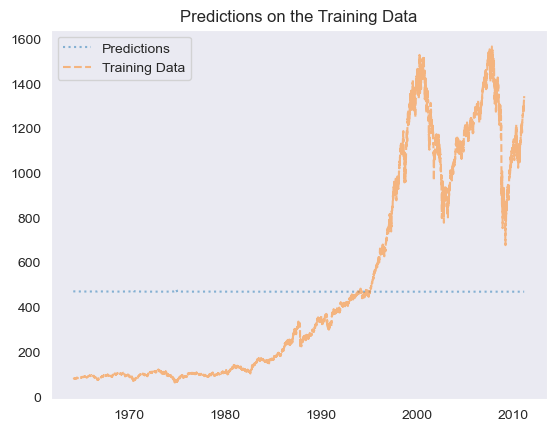

In [143]:
# Plotting the model on training data

# flattening the predictions into a array/vector
train_preds = model1.predict(X_train).flatten()

# plotting the predictions
plt.plot(list(price.index[:split_train]), train_preds, alpha = .5, linestyle=":")

# plotting the true training values
plt.plot(list(price.index[:split_train]), y_train, alpha = .5, linestyle="--")

# legend and title
plt.legend(["Predictions", "Training Data"])
plt.title("Predictions on the Training Data");

### Validation Predictions
The LSTM model does a reasonably good job of predicting values for about 18 months after the training data ended, albeit on a big of a lag. Then, the model loses all signal and begins to disappoint. This is another strong indication that our first model overfit the training data.

46/46 [==============================] - 0s 3ms/step


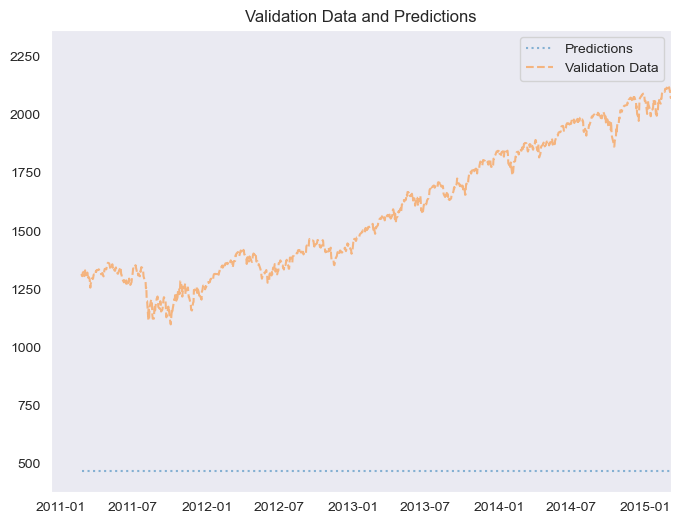

In [144]:
# Plotting the validation data

fig, ax = plt.subplots(figsize=(8,6))

# flattening the val preds into an array/vector 
val_preds = model1.predict(X_val).flatten()

# plotting val preds
ax.plot(list(price.index[split_train:split_val]), val_preds, alpha = .5, linestyle=":")

# plotting true validation values
ax.plot(list(price.index[split_train:split_val]),y_val, alpha = .5, linestyle="--")

# Title, legend, zooming in to see the moment of divergence
ax.legend(["Predictions", "Validation Data"])
ax.set_xlim(14950, 16500)
ax.set_title("Validation Data and Predictions");

### Test Predictions
These are overall very poor results. The training data had expired several years ago, and the model no longer possessed enough signal to maintain a grasp on what appropriate output values should look like. This is the embodiment of what a negative R-squared value looks like. 

46/46 [==============================] - 0s 3ms/step


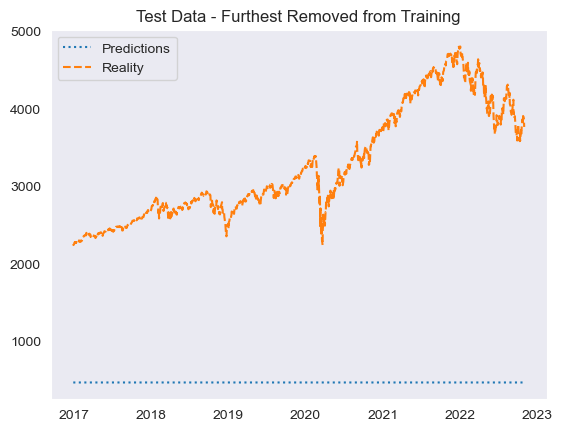

In [145]:
# Plotting test data

# Turn the predictions into an array/vector
y_preds = model1.predict(X_test).flatten()
# plot the predictions
plt.plot(list(price.index[split_val:]), y_preds, linestyle=":")
# plot the true values of the test data
plt.plot(list(price.index[split_val:]), y_test, linestyle="--")
plt.legend(["Predictions", "Reality"])
plt.title("Test Data - Furthest Removed from Training");

### All sections together
The further away in time that we get from the training data, the more unreliable and dislocated the predictions become. 

46/46 [==============================] - 0s 2ms/step


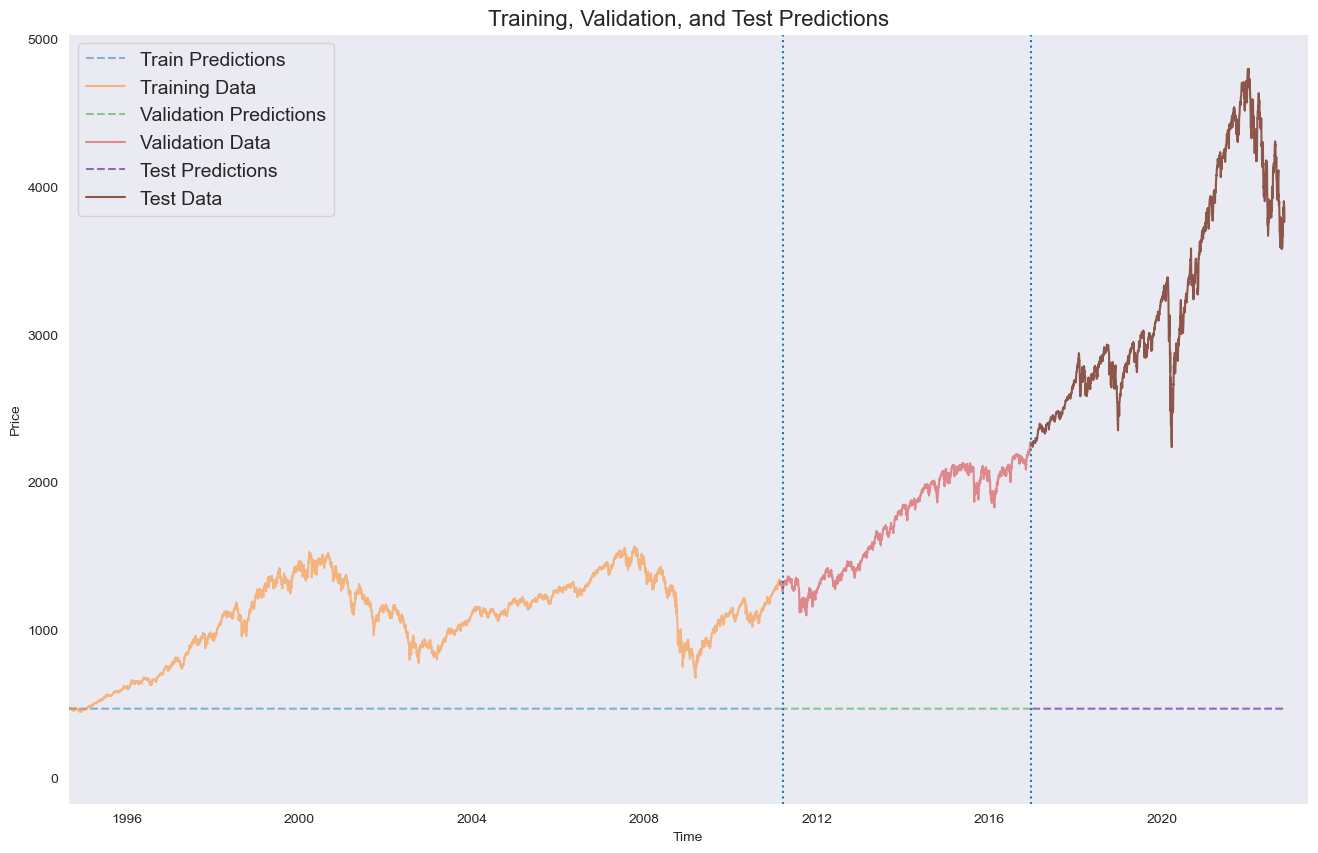

In [146]:
# Plotting the totality of the data, this is how future plots will look as well

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(list(price.index[:split_train]), train_preds, alpha = .5, linestyle="--")
ax.plot(list(price.index[:split_train]), y_train, alpha = .5)


ax.plot(list(price.index[split_train:split_val]), val_preds, alpha = .5, linestyle="--")
ax.plot(list(price.index[split_train:split_val]), y_val, alpha = .5)


y_preds = model1.predict(X_test)
plt.plot(list(price.index[split_val:]), y_preds, linestyle="--")
plt.plot(list(price.index[split_val:]), y_test)
plt.legend(["Predictions", "Reality"])



plt.legend(["Train Predictions", "Training Data", "Validation Predictions", "Validation Data",\
            "Test Predictions", "Test Data"], fontsize= 14)
plt.xlim(9000, 19500)
plt.title("Training, Validation, and Test Predictions", fontsize=16)
ax.axvline(15050, linestyle=":")
ax.set_ylabel("Price")
ax.set_xlabel("Time")
ax.axvline(17152, linestyle=":");

# Next Iteration
### Stacked LSTM
This version of the neural network uses two consecutive LSTM nodes. The key difference in the code is that we have to set "return_sequences" to True. This ensures that the correct input shape is given to the second layer of LSTM nodes. I will also increase the number of epochs used to train the data, meaning that the net has more repetitions of training to improve its model. 

In [147]:
# Define the model

# Sequential type
model2 = Sequential()

# LSTM Layer
model2.add(LSTM(50, return_sequences=True, input_shape=(15, 1)))

# 2nd/Stacked LSTM Layer
model2.add(LSTM(50))

# Hidden Dense Layer
model2.add(Dense(units=25, activation="relu"))


# Dense Output Layer - absence of activation argument means linear activation which is standard for regression
model2.add(Dense(1))

# Compile the model2
model2.compile(optimizer='adam', loss='mse')

# Fit it to the data
model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=50, shuffle=False)

Epoch 1/20
234/234 [==============================] - 8s 19ms/step - loss: 377231.1875 - val_loss: 2609078.2500
Epoch 2/20
234/234 [==============================] - 4s 15ms/step - loss: 323332.5000 - val_loss: 2389424.0000
Epoch 3/20
234/234 [==============================] - 4s 16ms/step - loss: 296192.0000 - val_loss: 2229918.0000
Epoch 4/20
234/234 [==============================] - 4s 15ms/step - loss: 305937.5312 - val_loss: 2252300.7500
Epoch 5/20
234/234 [==============================] - 4s 15ms/step - loss: 280825.3750 - val_loss: 2132820.7500
Epoch 6/20
234/234 [==============================] - 4s 16ms/step - loss: 439792.5312 - val_loss: 2930883.0000
Epoch 7/20
234/234 [==============================] - 4s 15ms/step - loss: 399118.0000 - val_loss: 2828184.7500
Epoch 8/20
234/234 [==============================] - 4s 16ms/step - loss: 374821.2500 - val_loss: 2731296.0000
Epoch 9/20
234/234 [==============================] - 4s 16ms/step - loss: 352874.0938 - val_loss: 26380

In [150]:
# Store performance metrics in the container
aggregate_model_stats("Stacked LSTM", model2, X_train, X_val, X_test, y_train, y_val, y_test)
metric_df

,Name,Train MAE,Train MSE,Train RMSE,Train MAPE,Train R^2,Val MAE,Val MSE,Val RMSE,Val MAPE,Val R^2,Test MAE,Test MSE,Test RMSE,Test MAPE,Test R^2
0,First LSTM,405.950451,223569.951395,472.831843,1.910742,-0.003950,1270.822782,1.723328e+06,1312.755960,0.719980,-14.907009,2795.425040,8.331501e+06,2886.434024,0.849803,-15.111966
1,Stacked LSTM,380.942025,246828.976728,496.818857,1.335407,-0.108396,1399.036955,2.065642e+06,1437.234174,0.796635,-18.066702,2923.639214,9.064766e+06,3010.775062,0.890919,-16.529999


46/46 [==============================] - 0s 4ms/step


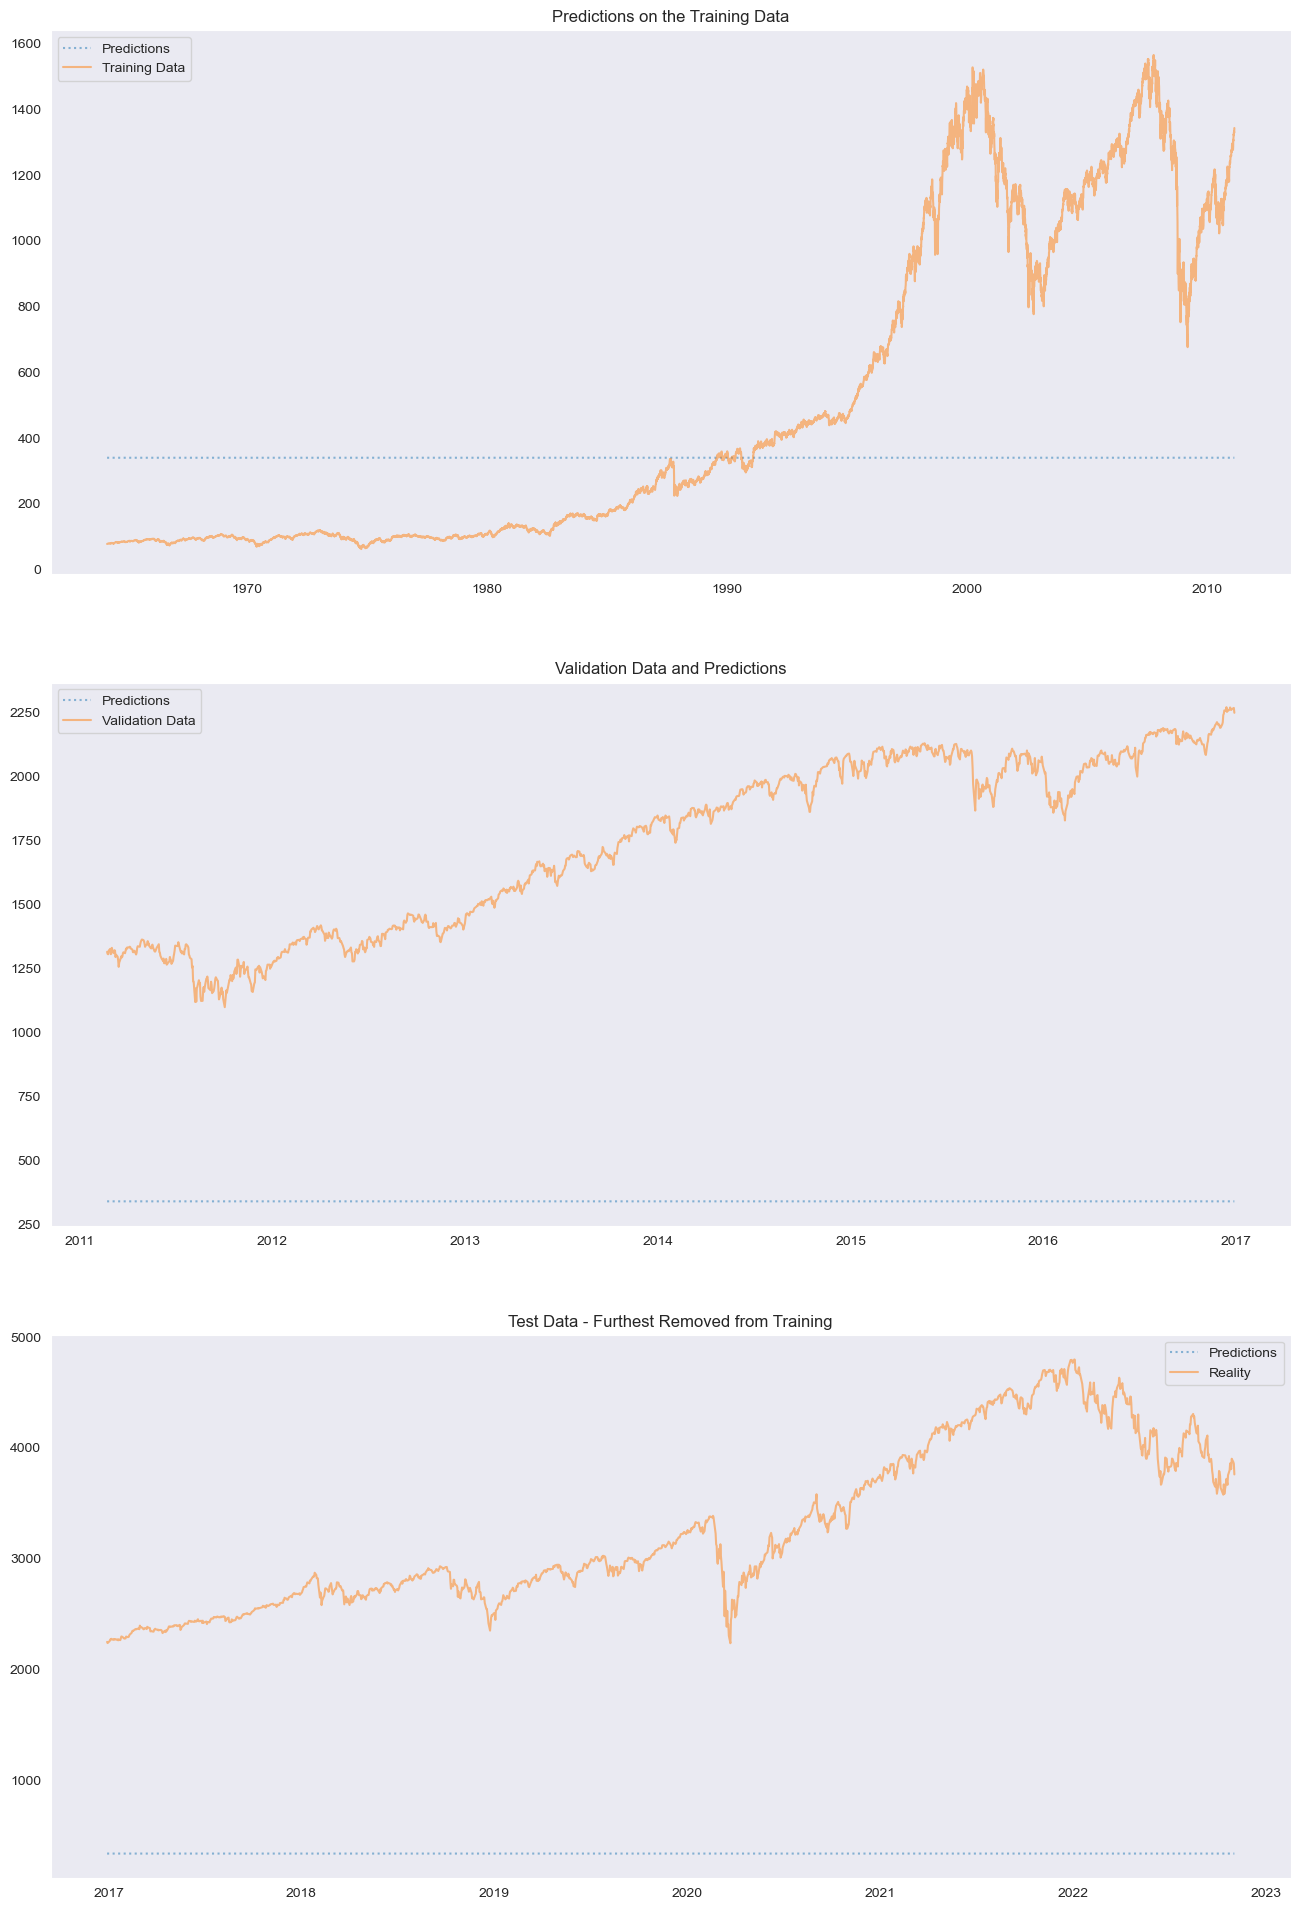

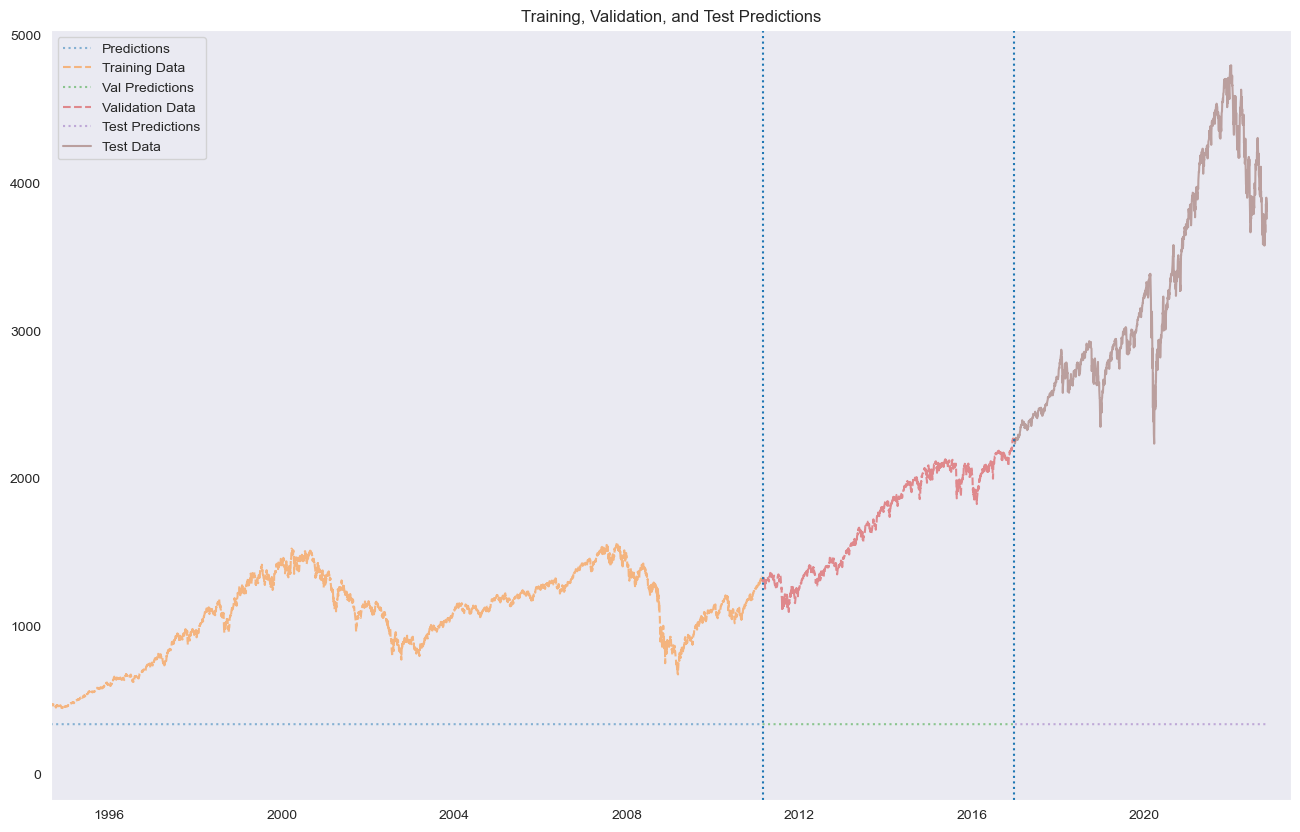

In [149]:
# Plot predictions vs true values 

plot_results(model2, X_train, X_val, X_test, y_train, y_val, y_test)

### Metrics Check

In [151]:
# printing key metrics
test_metric_check(model2, y_test, X_test)

46/46 [==============================] - 0s 4ms/step
RMSE: 3010.7750618596024 MAE: 2923.6392140525472 R-Squared: -16.52999928653566


In [152]:
# displaying the full data container
metric_df

,Name,Train MAE,Train MSE,Train RMSE,Train MAPE,Train R^2,Val MAE,Val MSE,Val RMSE,Val MAPE,Val R^2,Test MAE,Test MSE,Test RMSE,Test MAPE,Test R^2
0,First LSTM,405.950451,223569.951395,472.831843,1.910742,-0.003950,1270.822782,1.723328e+06,1312.755960,0.719980,-14.907009,2795.425040,8.331501e+06,2886.434024,0.849803,-15.111966
1,Stacked LSTM,380.942025,246828.976728,496.818857,1.335407,-0.108396,1399.036955,2.065642e+06,1437.234174,0.796635,-18.066702,2923.639214,9.064766e+06,3010.775062,0.890919,-16.529999


### Evaluation
There was not really any improvement in terms of performance yet.

<hr style="border: 2pt solid blue">

### Third Iteration of the model
For this iteration, we will keep the stacked layer of LSTM, but we will also remove one of the dense layers. Instead, we will move expediently from LSTM layers to output layers and see if that provides a different outcome.

In [153]:
# Define the model

# Sequential type
model3 = Sequential()

# LSTM Layer
model3.add(LSTM(50, return_sequences=True, input_shape=(15, 1)))

# 2nd/Stacked LSTM Layer
model3.add(LSTM(50))

# Dense Output Layer
model3.add(Dense(1))

# Compile the model3
model3.compile(optimizer='adam', loss='mse')

# Fit it to the data
model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=50, shuffle=False)

Epoch 1/100
234/234 [==============================] - 8s 19ms/step - loss: 447167.0000 - val_loss: 3037360.7500
Epoch 2/100
234/234 [==============================] - 4s 17ms/step - loss: 436999.7188 - val_loss: 3006259.7500
Epoch 3/100
234/234 [==============================] - 4s 16ms/step - loss: 428944.0000 - val_loss: 2977058.2500
Epoch 4/100
234/234 [==============================] - 4s 16ms/step - loss: 421346.6250 - val_loss: 2948877.2500
Epoch 5/100
234/234 [==============================] - 4s 16ms/step - loss: 414074.5625 - val_loss: 2921443.0000
Epoch 6/100
234/234 [==============================] - 4s 16ms/step - loss: 407074.9375 - val_loss: 2894632.2500
Epoch 7/100
234/234 [==============================] - 4s 16ms/step - loss: 400319.4688 - val_loss: 2868373.2500
Epoch 8/100
234/234 [==============================] - 4s 16ms/step - loss: 393789.9062 - val_loss: 2842622.7500
Epoch 9/100
234/234 [==============================] - 4s 15ms/step - loss: 387473.0312 - val_lo

Epoch 73/100
234/234 [==============================] - 3s 15ms/step - loss: 196309.9531 - val_loss: 1921613.2500
Epoch 74/100
234/234 [==============================] - 3s 14ms/step - loss: 193957.8750 - val_loss: 1906945.0000
Epoch 75/100
234/234 [==============================] - 3s 14ms/step - loss: 191266.6875 - val_loss: 1892667.8750
Epoch 76/100
234/234 [==============================] - 3s 14ms/step - loss: 188651.1562 - val_loss: 1878033.0000
Epoch 77/100
234/234 [==============================] - 3s 14ms/step - loss: 185523.3281 - val_loss: 1863690.5000
Epoch 78/100
234/234 [==============================] - 3s 14ms/step - loss: 183555.1406 - val_loss: 1849156.2500
Epoch 79/100
234/234 [==============================] - 4s 15ms/step - loss: 191289.4844 - val_loss: 1862202.5000
Epoch 80/100
234/234 [==============================] - 3s 14ms/step - loss: 186753.6719 - val_loss: 1820894.3750
Epoch 81/100
234/234 [==============================] - 3s 14ms/step - loss: 178911.2812

In [154]:
# Adding data to the container
aggregate_model_stats("Stacked LSTM - Less Dense", model3, X_train,X_val,X_test,y_train,y_val,y_test)
metric_df

46/46 [==============================] - 0s 4ms/step


,Name,Train MAE,Train MSE,Train RMSE,Train MAPE,Train R^2,Val MAE,Val MSE,Val RMSE,Val MAPE,Val R^2,Test MAE,Test MSE,Test RMSE,Test MAPE,Test R^2
0,First LSTM,405.950451,223569.951395,472.831843,1.910742,-0.003950,1270.822782,1.723328e+06,1312.755960,0.719980,-14.907009,2795.425040,8.331501e+06,2886.434024,0.849803,-15.111966
1,Stacked LSTM,380.942025,246828.976728,496.818857,1.335407,-0.108396,1399.036955,2.065642e+06,1437.234174,0.796635,-18.066702,2923.639214,9.064766e+06,3010.775062,0.890919,-16.529999
2,Stacked LSTM - Less Dense,290.659885,153159.506046,391.355984,0.909588,0.312231,1224.227030,1.607069e+06,1267.702251,0.692122,-13.833890,2748.828759,8.073160e+06,2841.330633,0.834860,-14.612370


While we did manage to achieve a positive training R^2, the test results are continuing to be atrocious. Validation R^2 continues to be negative as well.

46/46 [==============================] - 0s 4ms/step


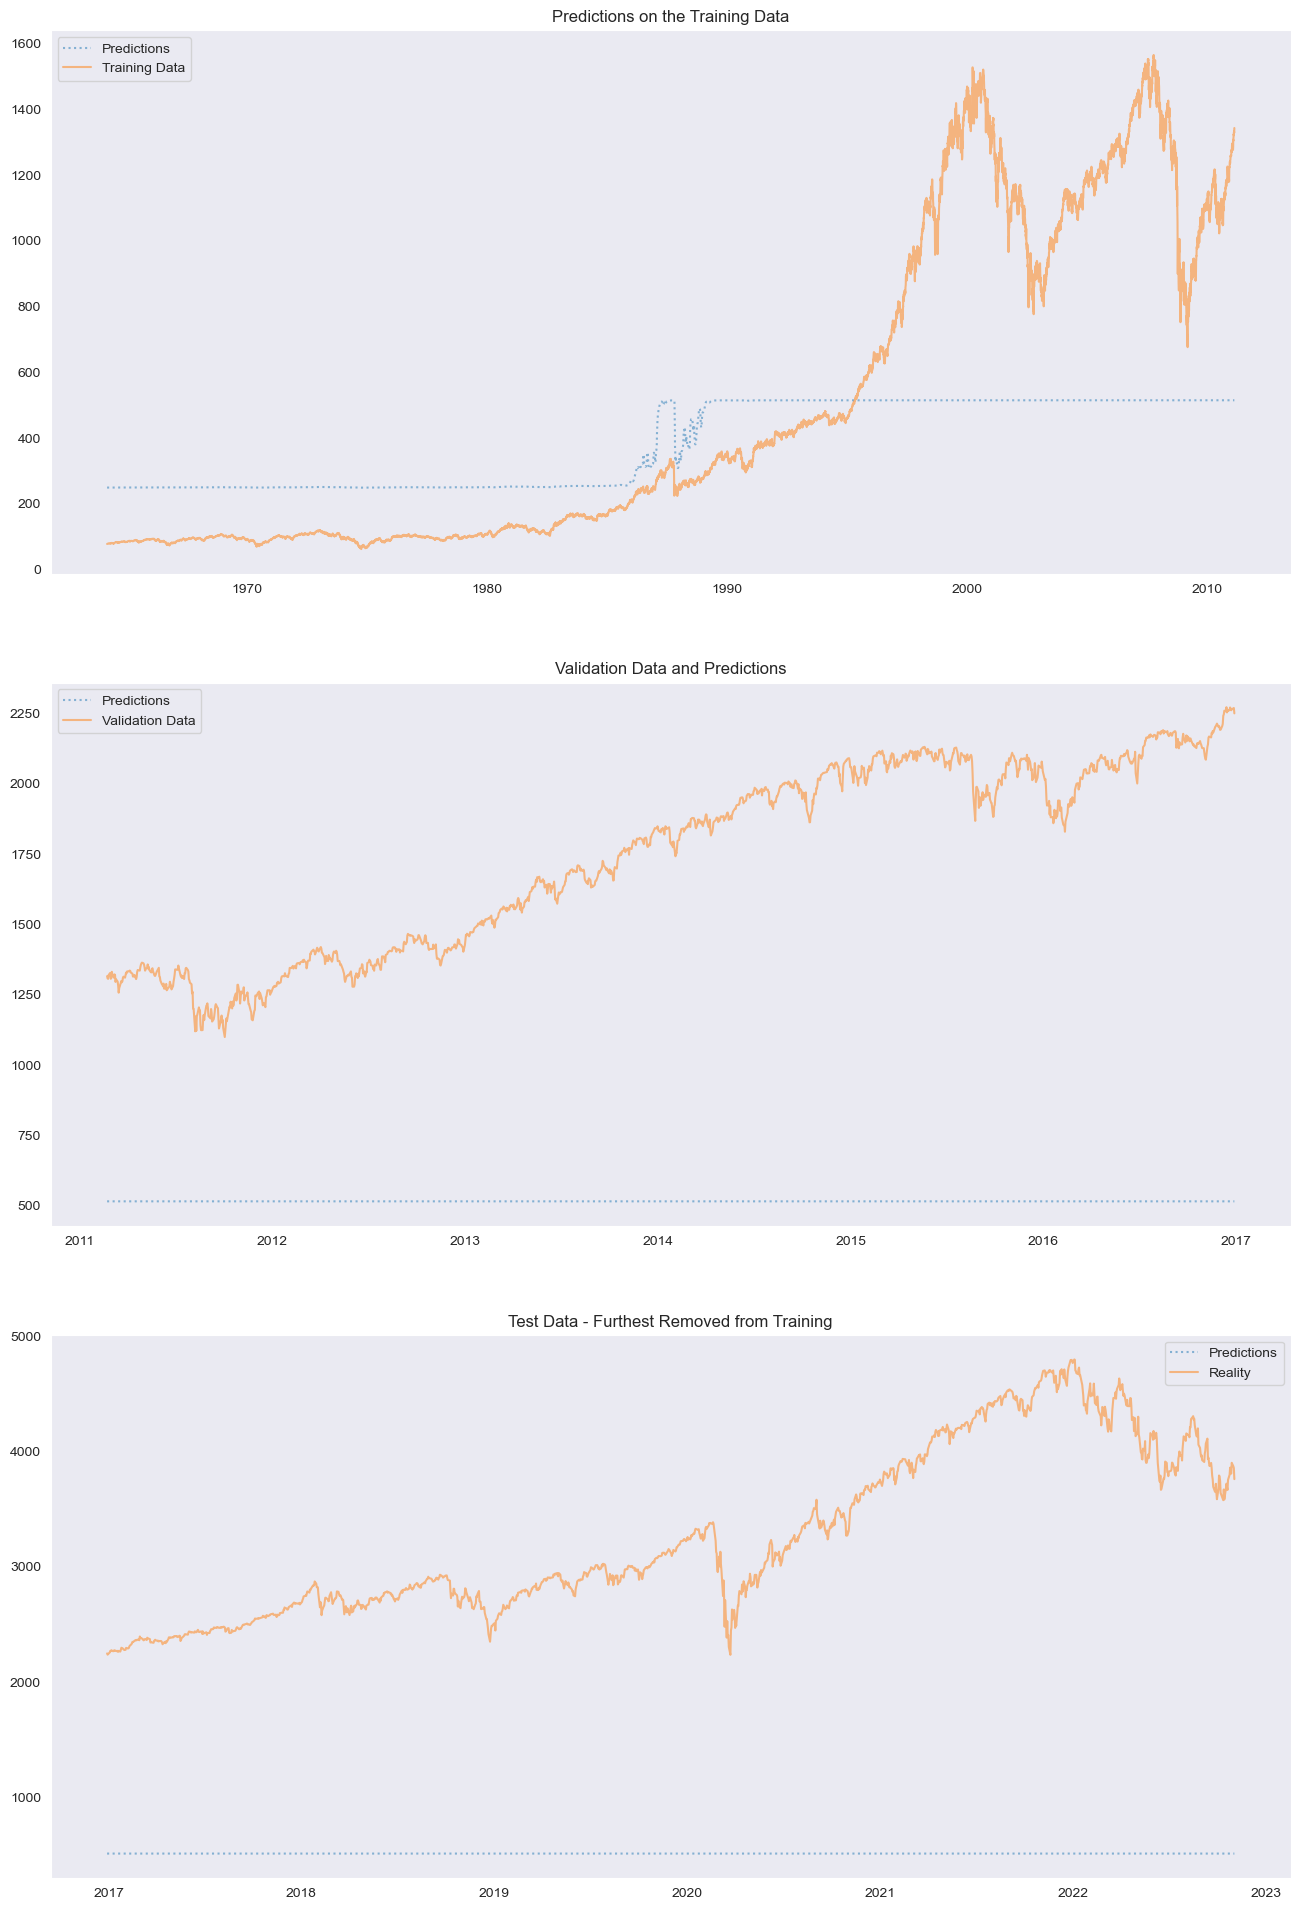

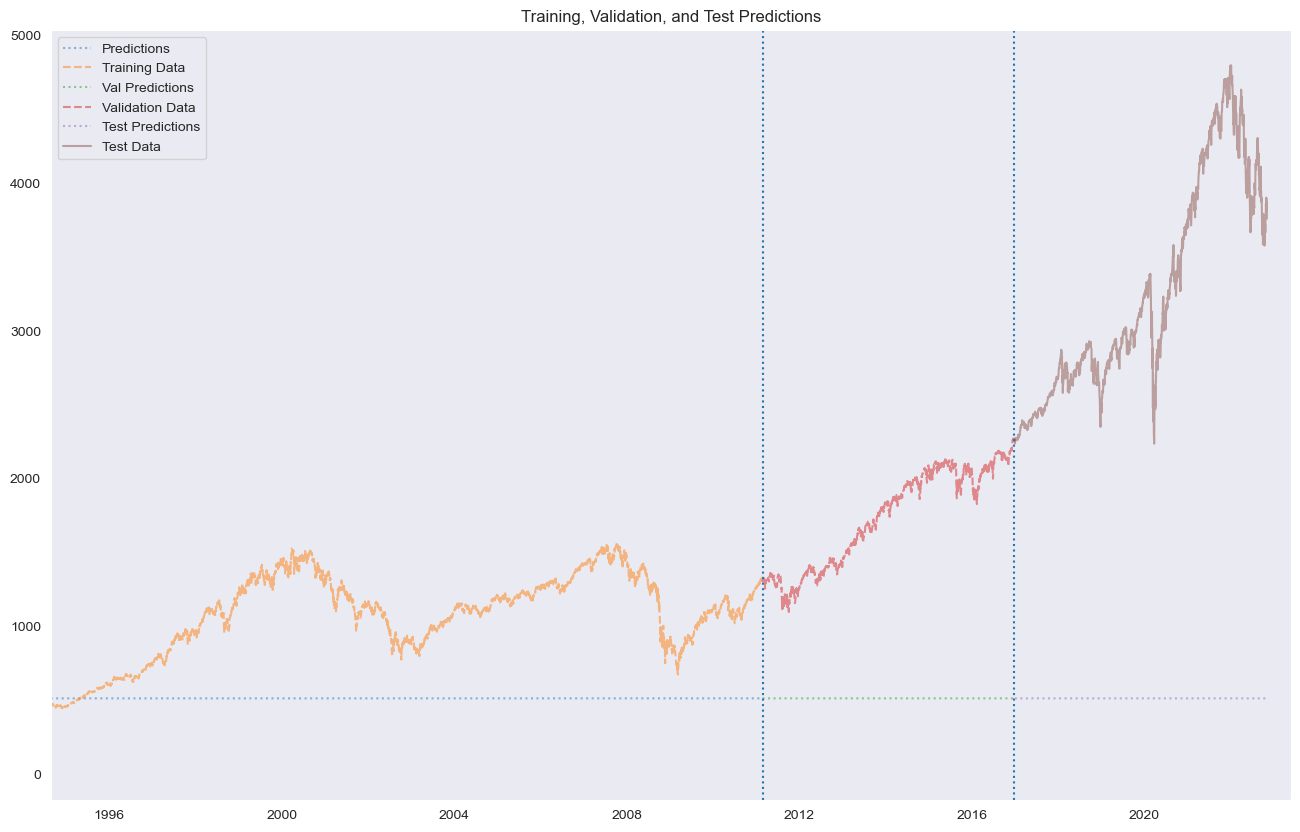

In [155]:
# Plotting the model
plot_results(model3, X_train, X_val, X_test, y_train, y_val, y_test)

### Evaluation
Trending the right direction ever so slightly. I am going to attempt to add different activation functions at the different levels of the network, and I will likely need to continue to add complexity to the models as well to generate better results. The number of epochs will also have to increase in order to yield better results. 

# Fourth Model
This iteration, I will specify that 'relu' will be used within each LSTM layer. 

In [156]:
# Define the model

# Sequential type
model4 = Sequential()

# LSTM Layer
model4.add(LSTM(50, activation="relu", return_sequences=True, input_shape=(15, 1)))

# 2nd/Stacked LSTM Layer
model4.add(LSTM(50, activation="relu"))

# Dense Output Layer
model4.add(Dense(1))

# Compile the model3
model4.compile(optimizer='adam', loss='mse')

# Fit it to the data
model4.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=50, shuffle=False)

Epoch 1/100
234/234 [==============================] - 7s 19ms/step - loss: 733.1972 - val_loss: 5451.1846
Epoch 2/100
234/234 [==============================] - 4s 18ms/step - loss: 280.4085 - val_loss: 1679.6477
Epoch 3/100
234/234 [==============================] - 4s 18ms/step - loss: 261.8794 - val_loss: 573.2565
Epoch 4/100
234/234 [==============================] - 4s 17ms/step - loss: 10647.6631 - val_loss: 196822.3281
Epoch 5/100
234/234 [==============================] - 4s 16ms/step - loss: 6163.8950 - val_loss: 1453.2401
Epoch 6/100
234/234 [==============================] - 4s 17ms/step - loss: 139.2909 - val_loss: 420.9387
Epoch 7/100
234/234 [==============================] - 4s 16ms/step - loss: 106.8755 - val_loss: 425.1874
Epoch 8/100
234/234 [==============================] - 4s 16ms/step - loss: 112.2290 - val_loss: 443.5974
Epoch 9/100
234/234 [==============================] - 4s 16ms/step - loss: 113.6843 - val_loss: 412.1425
Epoch 10/100
234/234 [===============

234/234 [==============================] - 4s 17ms/step - loss: 178.6701 - val_loss: 838.6427
Epoch 78/100
234/234 [==============================] - 4s 17ms/step - loss: 198.3288 - val_loss: 763.9390
Epoch 79/100
234/234 [==============================] - 4s 16ms/step - loss: 200.5968 - val_loss: 651.3853
Epoch 80/100
234/234 [==============================] - 4s 16ms/step - loss: 186.3893 - val_loss: 612.2690
Epoch 81/100
234/234 [==============================] - 4s 15ms/step - loss: 188.2459 - val_loss: 609.7303
Epoch 82/100
234/234 [==============================] - 4s 15ms/step - loss: 204.8643 - val_loss: 635.0184
Epoch 83/100
234/234 [==============================] - 4s 15ms/step - loss: 223.5428 - val_loss: 681.0253
Epoch 84/100
234/234 [==============================] - 4s 15ms/step - loss: 242.8363 - val_loss: 607.4758
Epoch 85/100
234/234 [==============================] - 3s 15ms/step - loss: 217.2845 - val_loss: 1550.6219
Epoch 86/100
234/234 [===========================

In [157]:
# Adding data to the container
aggregate_model_stats("Stacked LSTM - Relu, 100Ep", model4, X_train,X_val,X_test,y_train,y_val,y_test)
metric_df

46/46 [==============================] - 0s 4ms/step


,Name,Train MAE,Train MSE,Train RMSE,Train MAPE,Train R^2,Val MAE,Val MSE,Val RMSE,Val MAPE,Val R^2,Test MAE,Test MSE,Test RMSE,Test MAPE,Test R^2
0,First LSTM,405.950451,223569.951395,472.831843,1.910742,-0.003950,1270.822782,1.723328e+06,1312.755960,0.719980,-14.907009,2795.425040,8.331501e+06,2886.434024,0.849803,-15.111966
1,Stacked LSTM,380.942025,246828.976728,496.818857,1.335407,-0.108396,1399.036955,2.065642e+06,1437.234174,0.796635,-18.066702,2923.639214,9.064766e+06,3010.775062,0.890919,-16.529999
2,Stacked LSTM - Less Dense,290.659885,153159.506046,391.355984,0.909588,0.312231,1224.227030,1.607069e+06,1267.702251,0.692122,-13.833890,2748.828759,8.073160e+06,2841.330633,0.834860,-14.612370
3,"Stacked LSTM - Relu, 100Ep",8.520312,234.747488,15.321471,0.018627,0.998946,23.208291,8.963076e+02,29.938396,0.013823,0.991727,55.316302,6.231916e+03,78.942486,0.016739,0.987948


### WOW!
Our test R-squared went from 3 consecutive negative values to an unbelievable 98.8% of variance explained by the model. Changing the output of the layers made an UNBELIEVABLE difference on the results of the model.

46/46 [==============================] - 0s 4ms/step


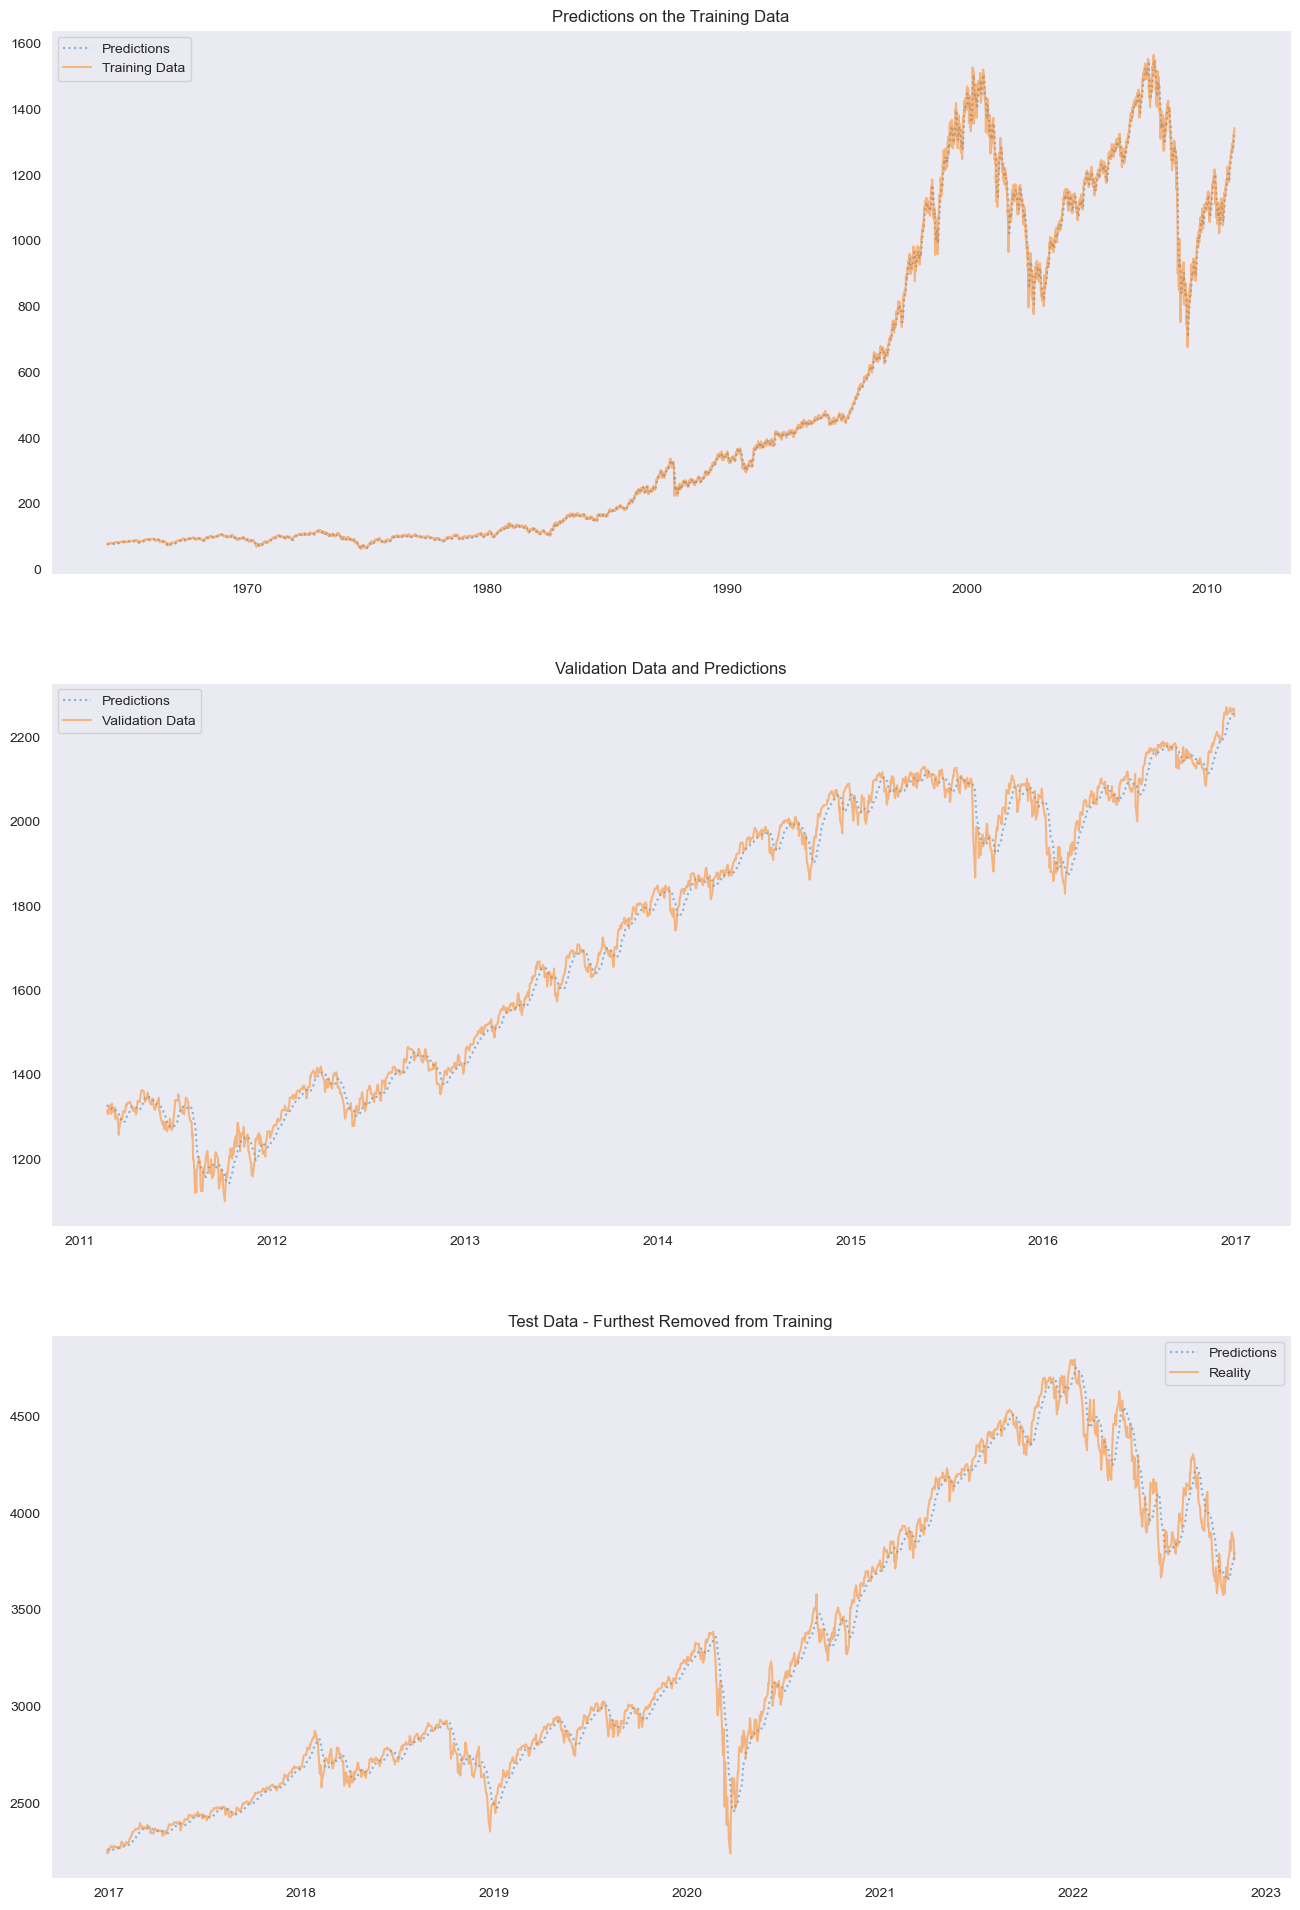

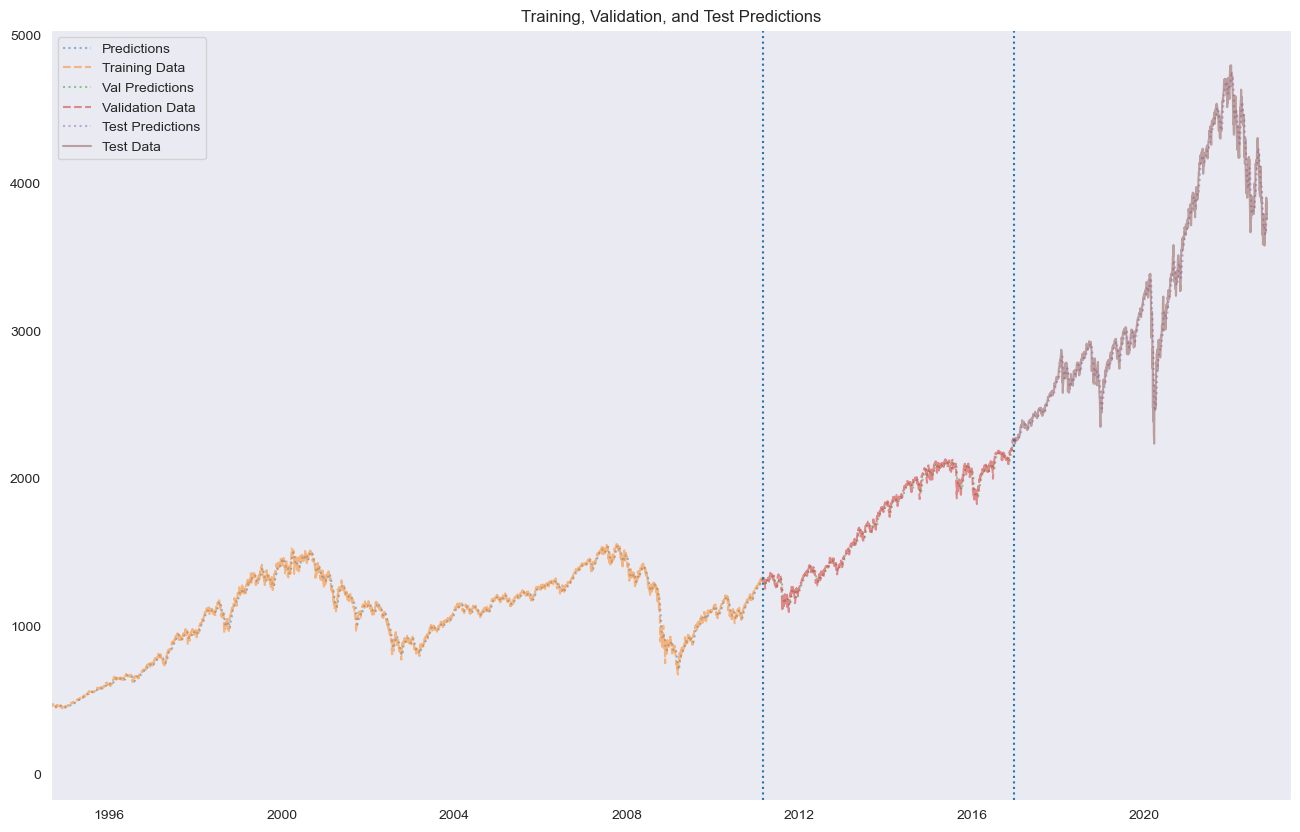

In [158]:
# Plotting the model
plot_results(model4, X_train, X_val, X_test, y_train, y_val, y_test)

46/46 [==============================] - 0s 4ms/step


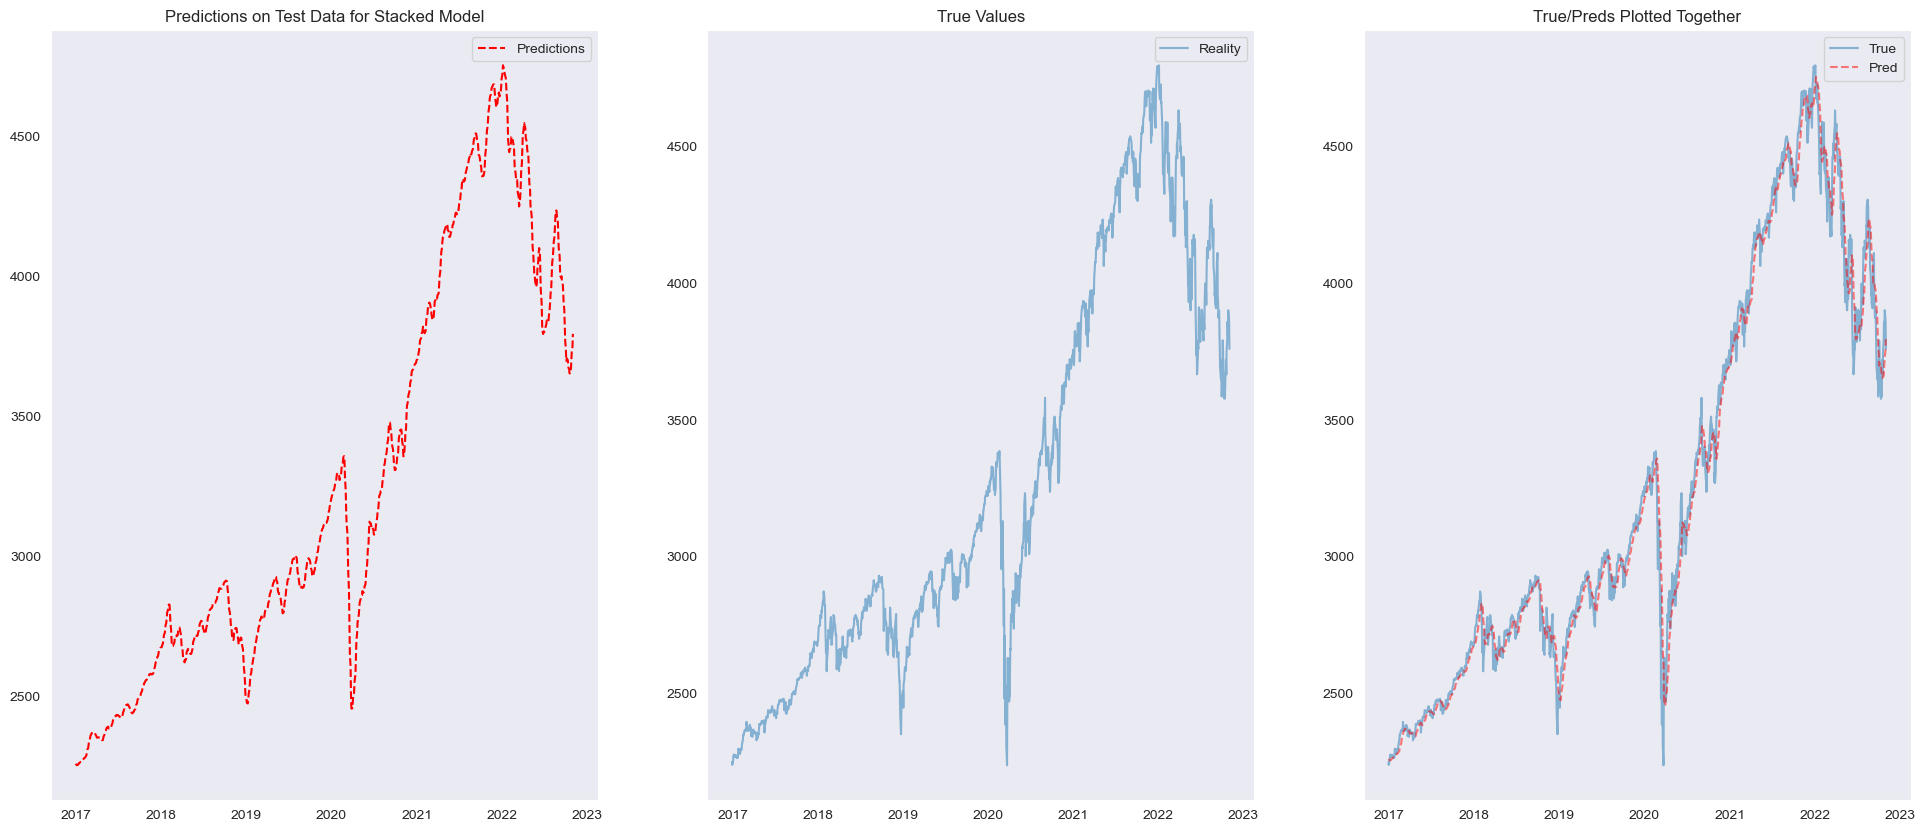

In [159]:
# Isolating the test values for direct comparison of predictions and true values

y_preds = model4.predict(X_test)
# Plotting the test data predictions vs reality, very impressive
fig, ax = plt.subplots(ncols=3, figsize = (24,10))
ax[0].plot(list(price.index[split_val:]), y_preds, linestyle="--", color="red")
ax[0].legend(["Predictions", "Reality"])
ax[0].set_title("Predictions on Test Data for Stacked Model")
ax[1].plot(list(price.index[split_val:]), y_test, alpha=.5)
ax[1].set_title("True Values")
ax[1].legend(["Reality"])
ax[2].set_title("True/Preds Plotted Together")
ax[2].plot(list(price.index[split_val:]), y_test, alpha=.5)
ax[2].plot(list(price.index[split_val:]), y_preds, linestyle="--", color="red", alpha=.5)
ax[2].legend(["True", "Pred"]);

In [160]:
metric_df

,Name,Train MAE,Train MSE,Train RMSE,Train MAPE,Train R^2,Val MAE,Val MSE,Val RMSE,Val MAPE,Val R^2,Test MAE,Test MSE,Test RMSE,Test MAPE,Test R^2
0,First LSTM,405.950451,223569.951395,472.831843,1.910742,-0.003950,1270.822782,1.723328e+06,1312.755960,0.719980,-14.907009,2795.425040,8.331501e+06,2886.434024,0.849803,-15.111966
1,Stacked LSTM,380.942025,246828.976728,496.818857,1.335407,-0.108396,1399.036955,2.065642e+06,1437.234174,0.796635,-18.066702,2923.639214,9.064766e+06,3010.775062,0.890919,-16.529999
2,Stacked LSTM - Less Dense,290.659885,153159.506046,391.355984,0.909588,0.312231,1224.227030,1.607069e+06,1267.702251,0.692122,-13.833890,2748.828759,8.073160e+06,2841.330633,0.834860,-14.612370
3,"Stacked LSTM - Relu, 100Ep",8.520312,234.747488,15.321471,0.018627,0.998946,23.208291,8.963076e+02,29.938396,0.013823,0.991727,55.316302,6.231916e+03,78.942486,0.016739,0.987948


### Evaluation
By changing the activation function of the LSTM layers, all of a sudden the model is producing far better results. The model was able to preserve signal from the input data, and make extremely accurate predictions. While the R^2 for train is higher than for test, both scores are explaining over 98% of variance. It is possible this could make future generalization difficult though. I will need to take some steps to prevent overfitting. 

<hr style="border: 2px solid blue">

### Model 5, Adding Early Stopping, Tensorboard
Now that we have made such a radical improvement in the quality of our model predictions, we can begin to look into different forms of regularization to prevent overfitting. Early stopping tells the net to stop training if the scores do not improve over a specified interval. The tensorboard functionality gives access to training logs and a few visualizations for the specific model iteration. This provides a bit of visibility into how the model's scores improve with each step or epoch.

In [161]:
# Define TensorBoard callback
tensorboard_callback = TensorBoard(log_dir="logs")

In [162]:
# Adding in an early stopping callback
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1, 
                           patience=10,
                           mode='min')

In [163]:
# Define the model

# Sequential type
model5 = Sequential()

# LSTM Layer
model5.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(15, 1)))

# 2nd/Stacked LSTM Layer
model5.add(LSTM(50, activation='relu'))

# Dense Output Layer
model5.add(Dense(1))

# Compile the model4
model5.compile(optimizer='adam', loss='mse')

# Fit it to the data
model5.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[tensorboard_callback, early_stop], epochs=100, \
           batch_size=50, shuffle=False)

Epoch 1/100
234/234 [==============================] - 6s 17ms/step - loss: 25655.6875 - val_loss: 3724.3184
Epoch 2/100
234/234 [==============================] - 4s 15ms/step - loss: 202.6774 - val_loss: 1031.3495
Epoch 3/100
234/234 [==============================] - 4s 15ms/step - loss: 211.1954 - val_loss: 1287.7241
Epoch 4/100
234/234 [==============================] - 4s 15ms/step - loss: 3668.7769 - val_loss: 3060.5059
Epoch 5/100
234/234 [==============================] - 4s 16ms/step - loss: 217.2452 - val_loss: 749.0250
Epoch 6/100
234/234 [==============================] - 4s 16ms/step - loss: 209.4132 - val_loss: 1010.2974
Epoch 7/100
234/234 [==============================] - 4s 15ms/step - loss: 205.8406 - val_loss: 772.4599
Epoch 8/100
234/234 [==============================] - 4s 15ms/step - loss: 189.3483 - val_loss: 596.2830
Epoch 9/100
234/234 [==============================] - 4s 15ms/step - loss: 205.7524 - val_loss: 738.3683
Epoch 10/100
234/234 [================

234/234 [==============================] - 3s 14ms/step - loss: 213.3631 - val_loss: 693.2168
Epoch 78/100
234/234 [==============================] - 3s 14ms/step - loss: 225.8312 - val_loss: 705.1877
Epoch 79/100
234/234 [==============================] - 4s 15ms/step - loss: 239.5553 - val_loss: 728.9969
Epoch 80/100
234/234 [==============================] - 3s 14ms/step - loss: 243.6251 - val_loss: 718.1768
Epoch 81/100
234/234 [==============================] - 3s 14ms/step - loss: 257.5961 - val_loss: 824.5396
Epoch 82/100
234/234 [==============================] - 3s 14ms/step - loss: 263.5817 - val_loss: 959.4456
Epoch 83/100
234/234 [==============================] - 3s 14ms/step - loss: 729.7688 - val_loss: 764.2095
Epoch 84/100
234/234 [==============================] - 3s 14ms/step - loss: 225.4211 - val_loss: 801.1020
Epoch 85/100
234/234 [==============================] - 4s 15ms/step - loss: 216.3670 - val_loss: 806.8532
Epoch 86/100
234/234 [============================

### Early Stopping Didn't Work
We never arrived at a local minimum in the loss function, and therefore the net continued to train until completion, we will need to investigate a different form of regulariztion in the next iteration. Train and test R squared scores were basically identical, but the test error scores all ticked higher slightly in a sign of worsening ultimate calibration.

In [165]:
# aggregate_model_stats("Stacked LSTM EarlyStop", model5, X_train, X_val, X_test, y_train, y_val, y_test)
metric_df

,Name,Train MAE,Train MSE,Train RMSE,Train MAPE,Train R^2,Val MAE,Val MSE,Val RMSE,Val MAPE,Val R^2,Test MAE,Test MSE,Test RMSE,Test MAPE,Test R^2
0,First LSTM,405.950451,223569.951395,472.831843,1.910742,-0.003950,1270.822782,1.723328e+06,1312.755960,0.719980,-14.907009,2795.425040,8.331501e+06,2886.434024,0.849803,-15.111966
1,Stacked LSTM,380.942025,246828.976728,496.818857,1.335407,-0.108396,1399.036955,2.065642e+06,1437.234174,0.796635,-18.066702,2923.639214,9.064766e+06,3010.775062,0.890919,-16.529999
2,Stacked LSTM - Less Dense,290.659885,153159.506046,391.355984,0.909588,0.312231,1224.227030,1.607069e+06,1267.702251,0.692122,-13.833890,2748.828759,8.073160e+06,2841.330633,0.834860,-14.612370
3,"Stacked LSTM - Relu, 100Ep",8.520312,234.747488,15.321471,0.018627,0.998946,23.208291,8.963076e+02,29.938396,0.013823,0.991727,55.316302,6.231916e+03,78.942486,0.016739,0.987948
4,Stacked LSTM EarlyStop,9.299677,237.829961,15.421737,0.029915,0.998932,22.104673,8.761876e+02,29.600466,0.013223,0.991912,53.038438,6.238041e+03,78.981271,0.015993,0.987936


<hr style="border: 2px solid blue">

### Dropout Layers
While excellent metrics have been achieved, our model is still SLIGHTLY overfit. This iteration, I will add dropout layers between the LSTM layers and see how that affects performance in hopes of maximizing the model's ability to generalize. The current scores are more than adequate, we are just hoping to improve the model ever so slightly more. 

In [166]:
# Define the model

# Sequential type
model6 = Sequential()

# LSTM Layer
model6.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(15, 1)))

# Dropout layer for regularization
model6.add(Dropout(.2))

# 2nd/Stacked LSTM Layer
model6.add(LSTM(50, activation='relu'))

# Dropout Layer for regularization
model6.add(Dropout(.2))

# Dense Output Layer
model6.add(Dense(1))

# Compile the model4
model6.compile(optimizer='adam', loss='mse')

# Fit it to the data
model6.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=tensorboard_callback, epochs=100, \
           batch_size=50, shuffle=False)

Epoch 1/100
234/234 [==============================] - 6s 17ms/step - loss: 13572.1123 - val_loss: 120583.0781
Epoch 2/100
234/234 [==============================] - 4s 16ms/step - loss: 9811.5176 - val_loss: 142857.6094
Epoch 3/100
234/234 [==============================] - 4s 17ms/step - loss: 8813.7930 - val_loss: 66196.3984
Epoch 4/100
234/234 [==============================] - 4s 16ms/step - loss: 8454.7334 - val_loss: 125147.5469
Epoch 5/100
234/234 [==============================] - 4s 16ms/step - loss: 17959.0684 - val_loss: 151065.1562
Epoch 6/100
234/234 [==============================] - 4s 16ms/step - loss: 11681.9883 - val_loss: 138529.0312
Epoch 7/100
234/234 [==============================] - 4s 16ms/step - loss: 10736.1406 - val_loss: 168257.1719
Epoch 8/100
234/234 [==============================] - 4s 16ms/step - loss: 8644.4863 - val_loss: 162400.8125
Epoch 9/100
234/234 [==============================] - 4s 16ms/step - loss: 7974.2168 - val_loss: 140389.5000
Epoch 1

Epoch 75/100
234/234 [==============================] - 4s 15ms/step - loss: 6155.1396 - val_loss: 119126.3438
Epoch 76/100
234/234 [==============================] - 4s 16ms/step - loss: 5750.5498 - val_loss: 124534.9688
Epoch 77/100
234/234 [==============================] - 4s 16ms/step - loss: 5858.5376 - val_loss: 134810.4375
Epoch 78/100
234/234 [==============================] - 4s 15ms/step - loss: 5900.6494 - val_loss: 116539.3516
Epoch 79/100
234/234 [==============================] - 4s 15ms/step - loss: 5821.6196 - val_loss: 147512.0156
Epoch 80/100
234/234 [==============================] - 4s 16ms/step - loss: 5733.0171 - val_loss: 144874.0938
Epoch 81/100
234/234 [==============================] - 4s 15ms/step - loss: 6709.7891 - val_loss: 106208.8438
Epoch 82/100
234/234 [==============================] - 4s 15ms/step - loss: 6200.0117 - val_loss: 133439.0000
Epoch 83/100
234/234 [==============================] - 4s 15ms/step - loss: 6449.5273 - val_loss: 155273.4375
E

In [167]:
aggregate_model_stats("2 LSTMs Dropout", model6, X_train, X_val, X_test, y_train, y_val, y_test)
metric_df

46/46 [==============================] - 0s 4ms/step


,Name,Train MAE,Train MSE,Train RMSE,Train MAPE,Train R^2,Val MAE,Val MSE,Val RMSE,Val MAPE,Val R^2,Test MAE,Test MSE,Test RMSE,Test MAPE,Test R^2
0,First LSTM,405.950451,223569.951395,472.831843,1.910742,-0.003950,1270.822782,1.723328e+06,1312.755960,0.719980,-14.907009,2795.425040,8.331501e+06,2886.434024,0.849803,-15.111966
1,Stacked LSTM,380.942025,246828.976728,496.818857,1.335407,-0.108396,1399.036955,2.065642e+06,1437.234174,0.796635,-18.066702,2923.639214,9.064766e+06,3010.775062,0.890919,-16.529999
2,Stacked LSTM - Less Dense,290.659885,153159.506046,391.355984,0.909588,0.312231,1224.227030,1.607069e+06,1267.702251,0.692122,-13.833890,2748.828759,8.073160e+06,2841.330633,0.834860,-14.612370
3,"Stacked LSTM - Relu, 100Ep",8.520312,234.747488,15.321471,0.018627,0.998946,23.208291,8.963076e+02,29.938396,0.013823,0.991727,55.316302,6.231916e+03,78.942486,0.016739,0.987948
4,Stacked LSTM EarlyStop,9.299677,237.829961,15.421737,0.029915,0.998932,22.104673,8.761876e+02,29.600466,0.013223,0.991912,53.038438,6.238041e+03,78.981271,0.015993,0.987936
5,2 LSTMs Dropout,107.554948,20592.621675,143.501295,0.253569,0.907528,364.749941,1.384855e+05,372.136454,0.209448,-0.278277,671.229366,4.729961e+05,687.747083,0.206106,0.085291


### Evaluation
This model, with added regulariztion of dropout layers, has once again caused the model's performance on test data to drop off considerably. Dropout regularization also seems to be detrimental to overall model performance. I will attempt to use L2 regularization in the next iteration.

In [170]:
# Showing final test metrics
metric_df[["Train R^2", "Val R^2", "Test MAE", "Test MSE", "Test RMSE", "Test MAPE", "Test R^2"]]

,Train R^2,Val R^2,Test MAE,Test MSE,Test RMSE,Test MAPE,Test R^2
0,-0.003950,-14.907009,2795.425040,8.331501e+06,2886.434024,0.849803,-15.111966
1,-0.108396,-18.066702,2923.639214,9.064766e+06,3010.775062,0.890919,-16.529999
2,0.312231,-13.833890,2748.828759,8.073160e+06,2841.330633,0.834860,-14.612370
3,0.998946,0.991727,55.316302,6.231916e+03,78.942486,0.016739,0.987948
4,0.998932,0.991912,53.038438,6.238041e+03,78.981271,0.015993,0.987936
5,0.907528,-0.278277,671.229366,4.729961e+05,687.747083,0.206106,0.085291


<hr style="border: 2px solid blue">

### Ridge Regularization
We will attempt to reduce any overfitting again, this time using Ridge regularization. If this proves ineffective, I may increase the number of LSTM layers, adding complexity, but then thereafter seek to regularize the outputs.

In [171]:
# Regularizer
from keras.regularizers import l2

# Define the model

# Sequential type
model7 = Sequential()

# LSTM Layer
model7.add(LSTM(50, activation='relu', kernel_regularizer=l2(0.01), return_sequences=True, input_shape=(15, 1)))

# 2nd/Stacked LSTM Layer
model7.add(LSTM(50, activation='relu', kernel_regularizer=l2(0.01)))

# Dense Output Layer
model7.add(Dense(1))

# Compile the model4
model7.compile(optimizer='adam', loss='mse')

# Fit it to the data
model7.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=tensorboard_callback, \
           epochs=100, batch_size=50, shuffle=False)

Epoch 1/100
234/234 [==============================] - 7s 18ms/step - loss: 698.5539 - val_loss: 1796.3303
Epoch 2/100
234/234 [==============================] - 4s 16ms/step - loss: 416.4333 - val_loss: 1732.5725
Epoch 3/100
234/234 [==============================] - 4s 15ms/step - loss: 4651.4775 - val_loss: 3213.8115
Epoch 4/100
234/234 [==============================] - 4s 16ms/step - loss: 583.7316 - val_loss: 11912.2188
Epoch 5/100
234/234 [==============================] - 4s 15ms/step - loss: 325.8040 - val_loss: 1245.9839
Epoch 6/100
234/234 [==============================] - 4s 16ms/step - loss: 350.2924 - val_loss: 1767.1163
Epoch 7/100
234/234 [==============================] - 4s 17ms/step - loss: 314.2348 - val_loss: 950.1600
Epoch 8/100
234/234 [==============================] - 3s 15ms/step - loss: 265.7489 - val_loss: 783.8590
Epoch 9/100
234/234 [==============================] - 4s 16ms/step - loss: 237.7038 - val_loss: 936.8168
Epoch 10/100
234/234 [================

234/234 [==============================] - 4s 16ms/step - loss: 199.0691 - val_loss: 1153.0479
Epoch 78/100
234/234 [==============================] - 4s 16ms/step - loss: 201.6153 - val_loss: 1617.5333
Epoch 79/100
234/234 [==============================] - 4s 16ms/step - loss: 202.6922 - val_loss: 1708.9905
Epoch 80/100
234/234 [==============================] - 4s 15ms/step - loss: 200.8907 - val_loss: 1183.3359
Epoch 81/100
234/234 [==============================] - 4s 15ms/step - loss: 192.1402 - val_loss: 1459.3937
Epoch 82/100
234/234 [==============================] - 4s 16ms/step - loss: 191.3451 - val_loss: 1586.0607
Epoch 83/100
234/234 [==============================] - 3s 15ms/step - loss: 229.1115 - val_loss: 1312.9161
Epoch 84/100
234/234 [==============================] - 4s 16ms/step - loss: 195.0851 - val_loss: 945.4494
Epoch 85/100
234/234 [==============================] - 4s 16ms/step - loss: 222.8758 - val_loss: 697.5102
Epoch 86/100
234/234 [=====================

In [172]:
aggregate_model_stats("2 LSTMs Ridge", model7, X_train, X_val, X_test, y_train, y_val, y_test)
metric_df

46/46 [==============================] - 0s 4ms/step


,Name,Train MAE,Train MSE,Train RMSE,Train MAPE,Train R^2,Val MAE,Val MSE,Val RMSE,Val MAPE,Val R^2,Test MAE,Test MSE,Test RMSE,Test MAPE,Test R^2
0,First LSTM,405.950451,223569.951395,472.831843,1.910742,-0.003950,1270.822782,1.723328e+06,1312.755960,0.719980,-14.907009,2795.425040,8.331501e+06,2886.434024,0.849803,-15.111966
1,Stacked LSTM,380.942025,246828.976728,496.818857,1.335407,-0.108396,1399.036955,2.065642e+06,1437.234174,0.796635,-18.066702,2923.639214,9.064766e+06,3010.775062,0.890919,-16.529999
2,Stacked LSTM - Less Dense,290.659885,153159.506046,391.355984,0.909588,0.312231,1224.227030,1.607069e+06,1267.702251,0.692122,-13.833890,2748.828759,8.073160e+06,2841.330633,0.834860,-14.612370
3,"Stacked LSTM - Relu, 100Ep",8.520312,234.747488,15.321471,0.018627,0.998946,23.208291,8.963076e+02,29.938396,0.013823,0.991727,55.316302,6.231916e+03,78.942486,0.016739,0.987948
4,Stacked LSTM EarlyStop,9.299677,237.829961,15.421737,0.029915,0.998932,22.104673,8.761876e+02,29.600466,0.013223,0.991912,53.038438,6.238041e+03,78.981271,0.015993,0.987936
5,2 LSTMs Dropout,107.554948,20592.621675,143.501295,0.253569,0.907528,364.749941,1.384855e+05,372.136454,0.209448,-0.278277,671.229366,4.729961e+05,687.747083,0.206106,0.085291
6,2 LSTMs Ridge,6.264785,150.167318,12.254278,0.012856,0.999326,17.370715,5.825399e+02,24.135863,0.010380,0.994623,38.905999,3.752400e+03,61.256839,0.011809,0.992743


### Evaluation
This model, with added Ridge regulariztion performed even better than our other successful model iterations. While dropout regularization seems to be a performance impediment, Ridge produced good model results. I think that we have established a model that would be suitable for grid searching and tuning hyper-parameters. Before we take that step, I would like to try one more model with additional LSTM layers, and still have regularization.

In [173]:
# Showing final test metrics
metric_df[["Train R^2", "Val R^2","Test MAE", "Test MSE", "Test RMSE", "Test MAPE", "Test R^2"]]

,Train R^2,Val R^2,Test MAE,Test MSE,Test RMSE,Test MAPE,Test R^2
0,-0.003950,-14.907009,2795.425040,8.331501e+06,2886.434024,0.849803,-15.111966
1,-0.108396,-18.066702,2923.639214,9.064766e+06,3010.775062,0.890919,-16.529999
2,0.312231,-13.833890,2748.828759,8.073160e+06,2841.330633,0.834860,-14.612370
3,0.998946,0.991727,55.316302,6.231916e+03,78.942486,0.016739,0.987948
4,0.998932,0.991912,53.038438,6.238041e+03,78.981271,0.015993,0.987936
5,0.907528,-0.278277,671.229366,4.729961e+05,687.747083,0.206106,0.085291
6,0.999326,0.994623,38.905999,3.752400e+03,61.256839,0.011809,0.992743


<hr style="border: 3pt solid blue">

### Adding More Complexity and Regularization
Further experimentation on the complexity of the model. The l2 regularization went very well last iteration. I'm still hoping to find an ideal balance of complexity and regularization.

In [178]:
# Define the model

# Sequential type
model8 = Sequential()

# LSTM Layer
model8.add(LSTM(50, activation='relu', kernel_regularizer=l2(0.01), return_sequences=True, input_shape=(15, 1)))

# 2nd/Stacked LSTM Layer
model8.add(LSTM(50, activation='relu', kernel_regularizer=l2(0.01), return_sequences=True))

# 3rd/Stacked LSTM Layer
model8.add(LSTM(30, activation='relu', kernel_regularizer=l2(0.01), return_sequences=True))

# 4th/Stacked LSTM Layer
model8.add(LSTM(20, activation='relu', kernel_regularizer=l2(0.01)))

# Dense Output Layer
model8.add(Dense(1))

# Compile the model4
model8.compile(optimizer='adam', loss='mse')

# Fit it to the data
model8.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[tensorboard_callback, early_stop], \
           epochs=100, batch_size=50, shuffle=False)

Epoch 1/100
234/234 [==============================] - 12s 33ms/step - loss: 362062.7812 - val_loss: 121140.2656
Epoch 2/100
234/234 [==============================] - 6s 28ms/step - loss: 359.1216 - val_loss: 421.2993
Epoch 3/100
234/234 [==============================] - 7s 29ms/step - loss: 128.4227 - val_loss: 751.2481
Epoch 4/100
234/234 [==============================] - 7s 29ms/step - loss: 151.7481 - val_loss: 577.0561
Epoch 5/100
234/234 [==============================] - 7s 29ms/step - loss: 120.2239 - val_loss: 536.5461
Epoch 6/100
234/234 [==============================] - 7s 28ms/step - loss: 115.6959 - val_loss: 482.0050
Epoch 7/100
234/234 [==============================] - 7s 30ms/step - loss: 114.0801 - val_loss: 421.7870
Epoch 8/100
234/234 [==============================] - 7s 31ms/step - loss: 123.4636 - val_loss: 517.0179
Epoch 9/100
234/234 [==============================] - 7s 30ms/step - loss: 113.2576 - val_loss: 388.7883
Epoch 10/100
234/234 [=================

In [179]:
aggregate_model_stats("4 LSTMs Ridge", model8, X_train, X_val, X_test, y_train, y_val, y_test)
metric_df

46/46 [==============================] - 0s 7ms/step


,Name,Train MAE,Train MSE,Train RMSE,Train MAPE,Train R^2,Val MAE,Val MSE,Val RMSE,Val MAPE,Val R^2,Test MAE,Test MSE,Test RMSE,Test MAPE,Test R^2
0,First LSTM,405.950451,223569.951395,472.831843,1.910742,-0.003950,1270.822782,1.723328e+06,1312.755960,0.719980,-14.907009,2795.425040,8.331501e+06,2886.434024,0.849803,-15.111966
1,Stacked LSTM,380.942025,246828.976728,496.818857,1.335407,-0.108396,1399.036955,2.065642e+06,1437.234174,0.796635,-18.066702,2923.639214,9.064766e+06,3010.775062,0.890919,-16.529999
2,Stacked LSTM - Less Dense,290.659885,153159.506046,391.355984,0.909588,0.312231,1224.227030,1.607069e+06,1267.702251,0.692122,-13.833890,2748.828759,8.073160e+06,2841.330633,0.834860,-14.612370
3,"Stacked LSTM - Relu, 100Ep",8.520312,234.747488,15.321471,0.018627,0.998946,23.208291,8.963076e+02,29.938396,0.013823,0.991727,55.316302,6.231916e+03,78.942486,0.016739,0.987948
4,Stacked LSTM EarlyStop,9.299677,237.829961,15.421737,0.029915,0.998932,22.104673,8.761876e+02,29.600466,0.013223,0.991912,53.038438,6.238041e+03,78.981271,0.015993,0.987936
5,2 LSTMs Dropout,107.554948,20592.621675,143.501295,0.253569,0.907528,364.749941,1.384855e+05,372.136454,0.209448,-0.278277,671.229366,4.729961e+05,687.747083,0.206106,0.085291
6,2 LSTMs Ridge,6.264785,150.167318,12.254278,0.012856,0.999326,17.370715,5.825399e+02,24.135863,0.010380,0.994623,38.905999,3.752400e+03,61.256839,0.011809,0.992743
7,4 LSTMs Ridge,107.552771,19432.072868,139.398970,0.266195,0.912739,340.917656,1.209253e+05,347.743148,0.196337,-0.116189,642.941053,4.387014e+05,662.345407,0.197165,0.151612


### Evaluation
The additional complexity did not improve model peformance at all, so when preparing the grid search in order to optimize hyper-parameters, I will use the previous model with light l2 regularization but less complexity. The scores for that model have the highest R^2 for train, val, and test.

In [180]:
# Showing final test metrics
metric_df[["Train R^2", "Val R^2","Test MAE", "Test MSE", "Test RMSE", "Test MAPE", \
           "Test R^2"]].sort_values(by="Test R^2", ascending=False)

,Train R^2,Val R^2,Test MAE,Test MSE,Test RMSE,Test MAPE,Test R^2
6,0.999326,0.994623,38.905999,3.752400e+03,61.256839,0.011809,0.992743
3,0.998946,0.991727,55.316302,6.231916e+03,78.942486,0.016739,0.987948
4,0.998932,0.991912,53.038438,6.238041e+03,78.981271,0.015993,0.987936
7,0.912739,-0.116189,642.941053,4.387014e+05,662.345407,0.197165,0.151612
5,0.907528,-0.278277,671.229366,4.729961e+05,687.747083,0.206106,0.085291
2,0.312231,-13.833890,2748.828759,8.073160e+06,2841.330633,0.834860,-14.612370
0,-0.003950,-14.907009,2795.425040,8.331501e+06,2886.434024,0.849803,-15.111966
1,-0.108396,-18.066702,2923.639214,9.064766e+06,3010.775062,0.890919,-16.529999


In [196]:
# 2 LSTMS Ridge is the best model out of the bunch

# metric_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/LSTM_DF.csv')

<hr style="border: 2px solid blue">

# GridSearchCV using SciKeras
In order to use the sklearn GridSearchCV functionality, we need to wrap our neural network in a scikeras wrapper. There aren't major structural changes to the composition, though the process changes, and it will be outlined below. 
### Moving away from the validation set
Given the excellent results we have gotten in these preliminary models, we will now combine train and val X data sets and train on more complete information in hopes of developing a better model again.

In [19]:
# Train on 90% test on 90-100% of total data, 
split_train = int(len(y) *.90)

# Splits
X_train, y_train = X[:split_train], y[:split_train]
X_test, y_test = X[split_train:], y[split_train:]

In [192]:
# Scikeras wrapper requires a callable to build a compatible model, so this is that function

def model_comp():
    model = Sequential()


    model.add(LSTM(50, activation='relu', kernel_regularizer=l2(0.01), return_sequences=True, input_shape=(15, 1)))
    model.add(LSTM(50, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mse')
    
    return model




kw = KerasRegressor(model=model_comp, optimizer="adam", loss="mse", metrics=["mean_absolute_error", 'mean_absolute_percentage_error'],\
                   batch_size=50, epochs=100, shuffle=False, random_state=13)

kw.fit(X_train, y_train)

Epoch 1/100
264/264 [==============================] - 6s 16ms/step - loss: 16596.6992
Epoch 2/100
264/264 [==============================] - 4s 15ms/step - loss: 478.1977
Epoch 3/100
264/264 [==============================] - 4s 16ms/step - loss: 278.9035
Epoch 4/100
264/264 [==============================] - 4s 16ms/step - loss: 259.3424
Epoch 5/100
264/264 [==============================] - 4s 16ms/step - loss: 599.7329
Epoch 6/100
264/264 [==============================] - 4s 15ms/step - loss: 299.9143
Epoch 7/100
264/264 [==============================] - 4s 15ms/step - loss: 365.2033
Epoch 8/100
264/264 [==============================] - 4s 16ms/step - loss: 258.5047
Epoch 9/100
264/264 [==============================] - 4s 17ms/step - loss: 263.2176
Epoch 10/100
264/264 [==============================] - 4s 16ms/step - loss: 283.3868
Epoch 11/100
264/264 [==============================] - 4s 16ms/step - loss: 239.3467
Epoch 12/100
264/264 [==============================] - 4s 16

264/264 [==============================] - 4s 15ms/step - loss: 157.5298
Epoch 97/100
264/264 [==============================] - 4s 15ms/step - loss: 146.9050
Epoch 98/100
264/264 [==============================] - 4s 16ms/step - loss: 147.3143
Epoch 99/100
264/264 [==============================] - 4s 16ms/step - loss: 156.6723
Epoch 100/100
264/264 [==============================] - 4s 16ms/step - loss: 150.0984


KerasRegressor(
	model=<function model_comp at 0x7ff4455ad000>
	build_fn=None
	warm_start=False
	random_state=13
	optimizer=adam
	loss=mse
	metrics=['mean_absolute_error', 'mean_absolute_percentage_error']
	batch_size=50
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=False
	run_eagerly=False
	epochs=100
)

In [194]:
# # make sure to maintain sequential time series cross validation
# tscv = TimeSeriesSplit(n_splits=5)

# params = {"optimizer":["adam", "rmsprop", "sgd"],
#          "batch_size":[16, 32, 50],
#          "epochs":[50, 100, 200]}

# grid = GridSearchCV(estimator=kw, param_grid=params, scoring='neg_mean_squared_error', cv=tscv, n_jobs=6)


# grid.fit(X=X_train, y=y_train)

<hr style="border: 3px solid blue">

### Testing Model's Ability to Predict without Data

In [21]:
# Regularizer
from keras.regularizers import l2

# Define the model

# Sequential type
model7 = Sequential()

# LSTM Layer
model7.add(LSTM(50, activation='relu', kernel_regularizer=l2(0.01), return_sequences=True, input_shape=(15, 1)))

# 2nd/Stacked LSTM Layer
model7.add(LSTM(50, activation='relu', kernel_regularizer=l2(0.01)))

# Dense Output Layer
model7.add(Dense(1))

# Compile the model4
model7.compile(optimizer='adam', loss='mse')

# Fit it to the data
model7.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=50, shuffle=False)

Epoch 1/100
264/264 [==============================] - 7s 18ms/step - loss: 9018.0947 - val_loss: 3806.5759
Epoch 2/100
264/264 [==============================] - 4s 14ms/step - loss: 8081.5742 - val_loss: 3414.2971
Epoch 3/100
264/264 [==============================] - 4s 16ms/step - loss: 266.8577 - val_loss: 3442.8123
Epoch 4/100
264/264 [==============================] - 4s 15ms/step - loss: 237.1702 - val_loss: 3544.2122
Epoch 5/100
264/264 [==============================] - 4s 16ms/step - loss: 210.0402 - val_loss: 3670.8047
Epoch 6/100
264/264 [==============================] - 4s 15ms/step - loss: 197.0288 - val_loss: 3268.6755
Epoch 7/100
264/264 [==============================] - 4s 14ms/step - loss: 199.9751 - val_loss: 3145.2773
Epoch 8/100
264/264 [==============================] - 4s 15ms/step - loss: 219.4170 - val_loss: 2918.6807
Epoch 9/100
264/264 [==============================] - 4s 14ms/step - loss: 237.4381 - val_loss: 2897.6880
Epoch 10/100
264/264 [=============

Epoch 77/100
264/264 [==============================] - 4s 14ms/step - loss: 291.0515 - val_loss: 2616.1030
Epoch 78/100
264/264 [==============================] - 4s 15ms/step - loss: 238.7799 - val_loss: 3274.5127
Epoch 79/100
264/264 [==============================] - 4s 15ms/step - loss: 294.8206 - val_loss: 2569.8787
Epoch 80/100
264/264 [==============================] - 3s 13ms/step - loss: 233.3327 - val_loss: 3135.4946
Epoch 81/100
264/264 [==============================] - 4s 14ms/step - loss: 290.0935 - val_loss: 2582.0403
Epoch 82/100
264/264 [==============================] - 4s 14ms/step - loss: 230.4494 - val_loss: 3166.8181
Epoch 83/100
264/264 [==============================] - 4s 16ms/step - loss: 286.0262 - val_loss: 2571.7236
Epoch 84/100
264/264 [==============================] - 4s 14ms/step - loss: 236.0341 - val_loss: 3025.2268
Epoch 85/100
264/264 [==============================] - 4s 15ms/step - loss: 294.4180 - val_loss: 2486.3108
Epoch 86/100
264/264 [======

### While Loop to Replace X-Data
What happens when the model is forced to predict into the future without any new data? This loop replaces the furthest-removed closing price each time through and inserts the model's most recent prediction at the beginning of the array. This means that by the final predicted value, the model is making predictions based on its own past predictions.

In [83]:
# Loop to replace the true X_test data
c = 0
predictions = []
data = X_test[0]
while c < 15:
    c+=1
    y_pred = model7.predict(data.reshape(1, 15, 1))
    predictions.append(y_pred)
    data = np.delete(data, -1)
    data = np.insert(data, 0, y_pred)
    
predictions = [float(i) for i in predictions]

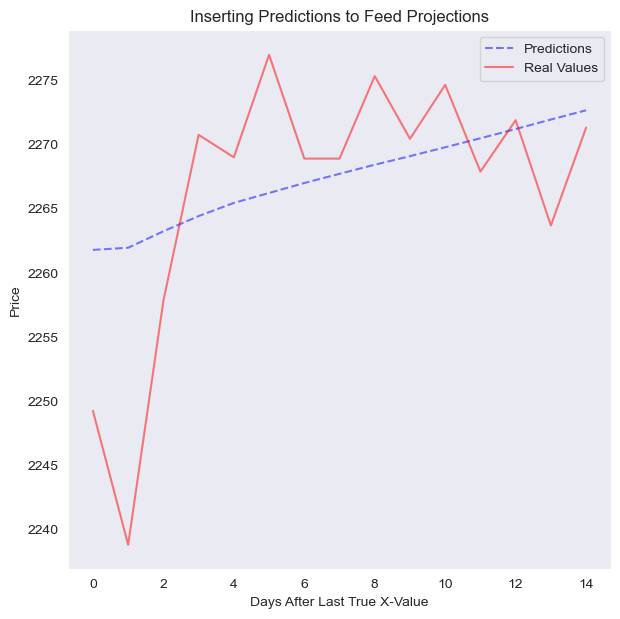

In [79]:
# Plotting Predictions of re-supplied X_data

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(predictions, color="blue", alpha=.5, linestyle="--")
ax.plot(y_test[:15], color = "red", alpha=.5)
ax.legend(["Predictions", "Real Values"])
ax.set_title("Inserting Predictions to Feed Projections")
ax.set_ylabel("Price")
ax.set_xlabel("Days After Last True X-Value");

### Once more for a 30-day time period

In [82]:
# Loop to replace the true X_test data
c = 0
predictions = []
data = X_test[0]
while c < 30:
    c+=1
    y_pred = model7.predict(data.reshape(1, 15, 1))
    predictions.append(y_pred)
    data = np.delete(data, -1)
    data = np.insert(data, 0, y_pred)
    
predictions = [float(i) for i in predictions]

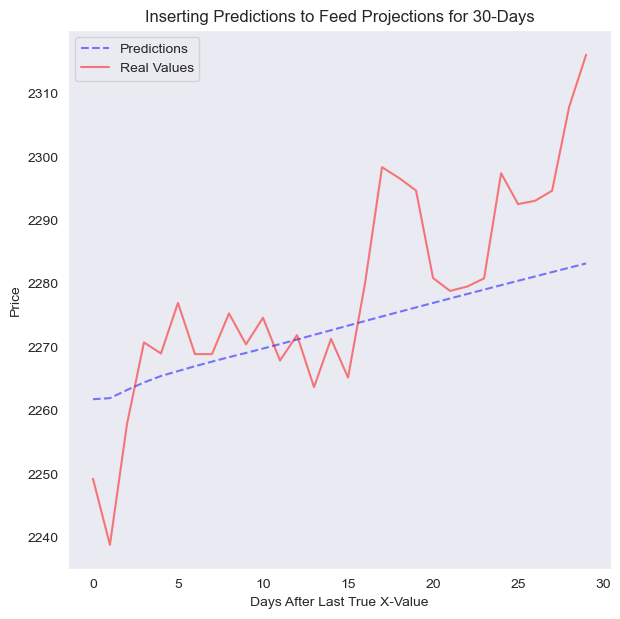

In [81]:
# Plotting Predictions of re-supplied X_data

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(predictions, color="blue", alpha=.5, linestyle="--")
ax.plot(y_test[:30], color = "red", alpha=.5)
ax.legend(["Predictions", "Real Values"])
ax.set_title("Inserting Predictions to Feed Projections for 30-Days")
ax.set_ylabel("Price")
ax.set_xlabel("Days After Last True X-Value");

<hr style="border: 3px solid black">

# Conclusion
I was encouraged by this model's ability to improve over iterations. The eventual R^2 scores I was able to achieve were very very good, but I still think that they lacked the single-day accuracy to truly be beneficial. A 1.2% mean absolute percentage error is small in the grand scheme of things, however in the realm of the stock market, a 1.2% error on a day is very substantial, and likely doesn't provide any actual value. These last plots above show that this model isn't well suited to forecast prices long into the future either. There seems to be too much randomness in the stock market to actually make very valuable modeled predictions, at least with the amount of data and features in my current sets. As a linear regression project, this model performed very well, but for any kind of application purpose, this model is still inadequate in my opinion. 